## Подбор релевантных товаров

Что надо сделать?

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

Данные

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
- validation_answer.csv - правильные ответы к предыдущему файлу.


## Загрузка данных

Выгрузка необходимых библиотек.

In [1]:
#pip install faiss-cpu -q

In [2]:
#pip install imblearn -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import faiss

from imblearn.pipeline import Pipeline, make_pipeline

from catboost import CatBoostClassifier

Выгрузка данных.

Выгрузим анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

In [4]:
df_base = pd.read_csv(r"C:\Users\Вика\Desktop\practicum\Master_2\base.csv", index_col=0)
df_base

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.766320,-2.505783,65.315285,135.051590,-1074.464888,0.319401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744755-base,-125.086300,4.735448,38.284935,-125.27671,209.788360,-47.870010,-628.127378,-71.077340,125.534355,29.341850,...,-70.364395,55.428260,-191.53702,122.978279,65.515260,108.963715,-52.795380,117.254510,-615.998268,-77.768555
4744759-base,-108.598390,5.454173,-22.191975,-158.71666,113.606110,-88.843430,-117.234538,137.317690,129.056690,164.754240,...,-70.360190,18.439003,-90.65145,-28.586794,68.691666,1.636499,-24.388298,93.530540,-1074.464888,-90.800400
4744762-base,-97.026730,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-759.626065,-108.151955,124.810135,118.760700,...,-55.961933,62.923470,-169.11832,108.452806,68.592970,43.205433,69.029830,129.536650,-1074.464888,4.718300


Выгрузим обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

In [5]:
df_train = pd.read_csv(r"C:\Users\Вика\Desktop\practicum\Master_2\train.csv", index_col=0)
df_train

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.092070,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995-query,-68.180530,11.657515,-63.179720,-188.726530,131.113100,-65.125340,-514.276885,95.990750,118.761185,-5.635696,...,38.573555,-133.087130,14.040794,66.477340,-36.148730,61.689774,107.037950,-1074.464888,-35.128250,811868-base
99996-query,-66.540890,2.201112,-70.292114,-146.167850,77.817140,-47.525654,-118.994688,-25.183374,131.499820,183.260880,...,33.324960,-110.576416,-84.448525,65.818100,-30.268772,133.784000,154.495860,-1144.590904,-108.663510,1460772-base
99997-query,-53.948240,4.726887,-29.278950,-147.182830,264.090670,-101.135630,-427.544045,68.057560,118.084310,192.449250,...,-14.146965,-184.663830,22.971385,67.347800,110.437100,35.785603,111.616710,-714.897734,-4.270569,2366140-base


Разделим обучающий датасет на таргеты (id товара из base.csv, который максимально похож на вектор обучающий выборки (по мнению экспертов)) и признаки.

In [6]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Выгрузим валидационный датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv. 

In [7]:
df_validation = pd.read_csv(r"C:\Users\Вика\Desktop\practicum\Master_2\validation.csv", index_col=0)
df_validation

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.441830,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.077160,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.795410,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.636410,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.236110,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.183960,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.568120,101.700640,-1171.892332,-125.307890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995-query,-46.672780,6.644193,7.376480,-116.126400,80.031715,-48.248695,-17.696937,108.150240,122.729744,103.643906,...,-65.641110,62.823895,-148.86781,-66.402868,66.99333,76.524155,66.525670,112.273720,-177.375834,-82.804726
199996-query,-94.786316,10.852646,13.700245,-125.619385,21.545967,-89.625534,79.880236,-46.513206,123.578730,74.033020,...,-65.032900,38.019740,-113.62750,-18.436499,64.16223,-117.032380,94.026490,86.279526,-1271.502930,-63.491104
199997-query,-59.224453,13.585838,22.655106,-134.926030,145.205690,-63.278100,-109.805058,16.277431,128.150040,168.835420,...,-48.826626,39.679783,-149.33646,160.609919,71.55922,25.237282,-35.985450,97.924790,73.080770,-28.081186


Также выгрузим правильные ответы к валидационному датасету.

In [8]:
df_validation_answer = pd.read_csv(r"C:\Users\Вика\Desktop\practicum\Master_2\validation_answer.csv", index_col=0)
df_validation_answer

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base
...,...
199995-query,967418-base
199996-query,1344948-base
199997-query,1690782-base


Вывод:

Были выгружены следующие данные:

- df_base (2918139 x 72) - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- df_train (1000000 x 72) - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) и вектор признаков размерностью 72. 
- targets - id товара из base.csv, который максимально похож на вектор обучающего датасета (по мнению экспертов).
- df_validation (1000000 x 72) - валидационный датасет с товарами (уникальный id и вектор признаков размерностью 72).
- df_validation_answer - правильные ответы валидационного датасеты.

## Предобработка и анализ данных

Проверим есть ли пропуски в базовом датасете.

In [9]:
sum(df_base.isna().sum())

0

Пропусков нет.

Проверим есть ли дубликаты в базовом датасете.

In [10]:
df_base.duplicated().sum()

0

Дубликатов нет.

Проанализируем данные в базовом датасете и проверим есть ли в них выбросы и аномалии.

In [11]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


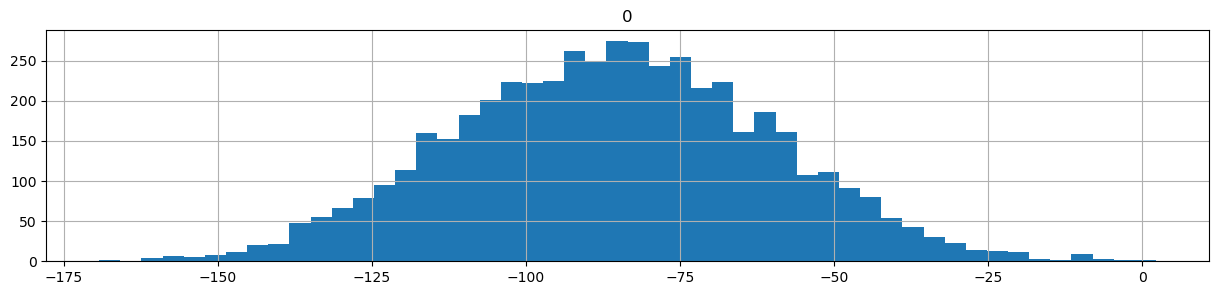

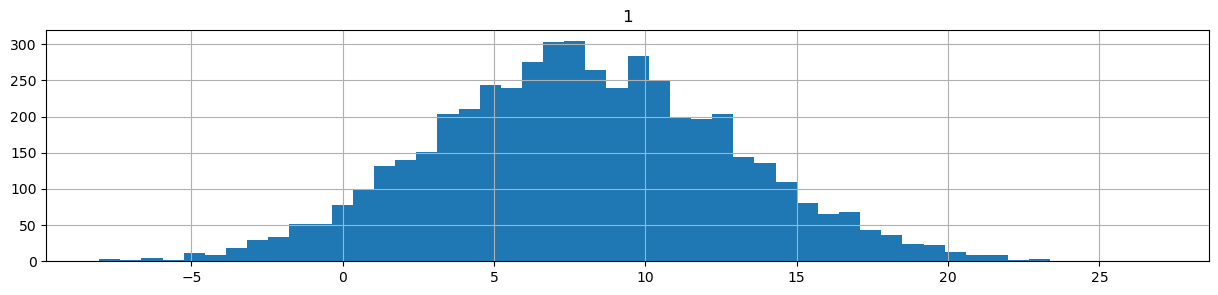

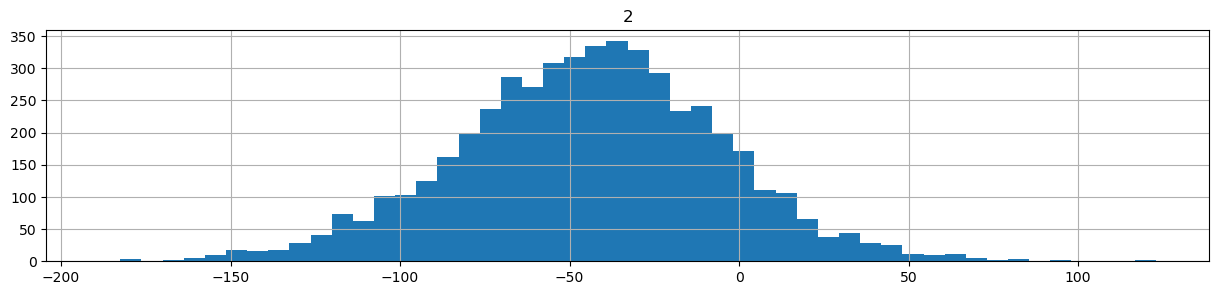

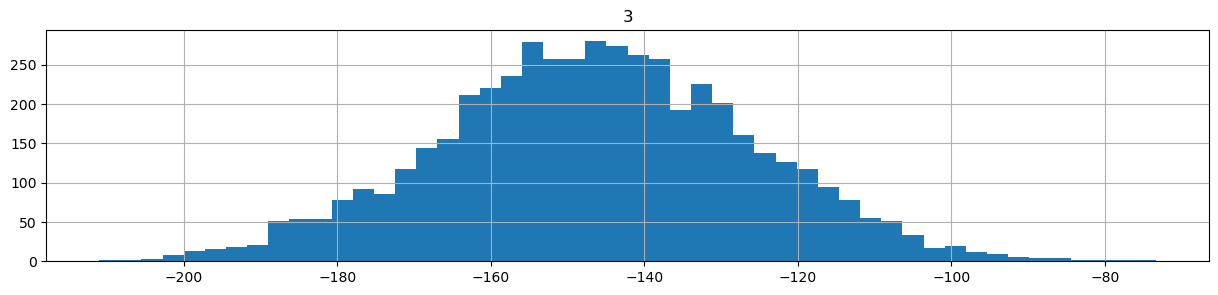

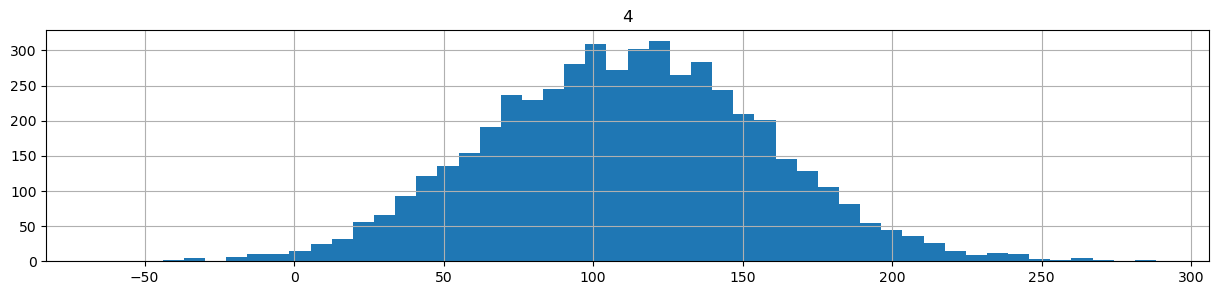

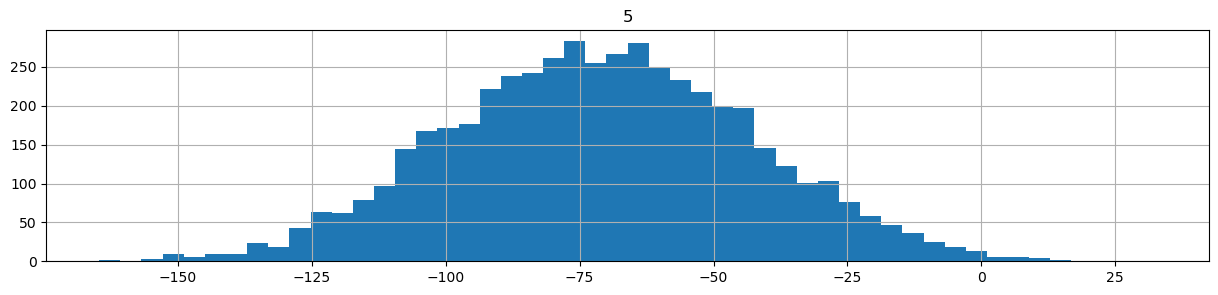

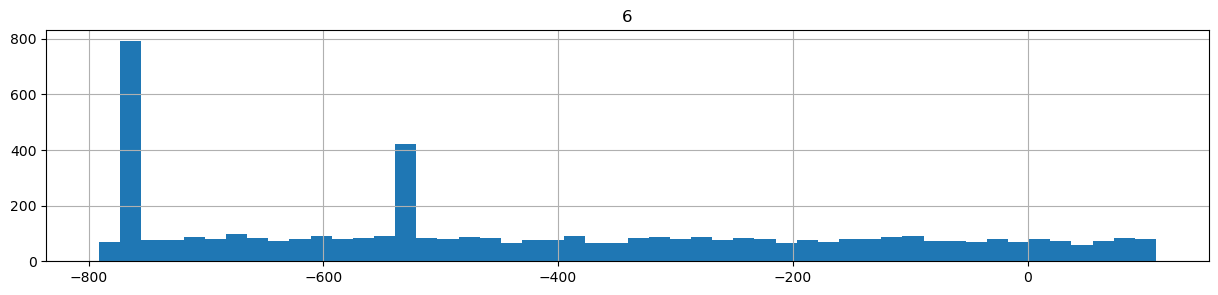

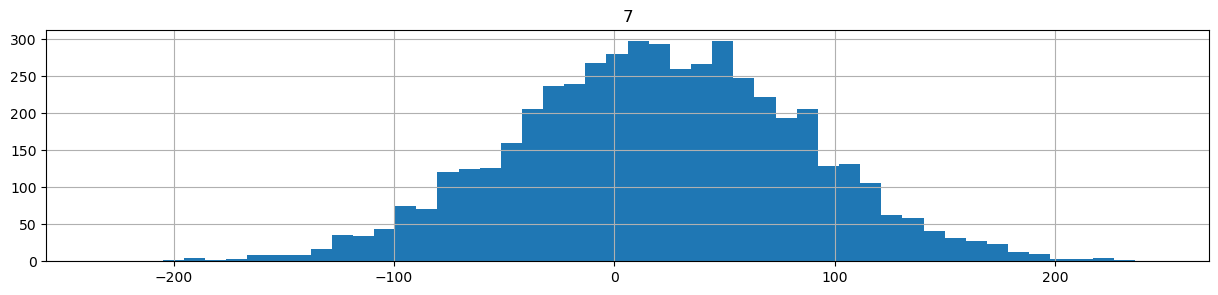

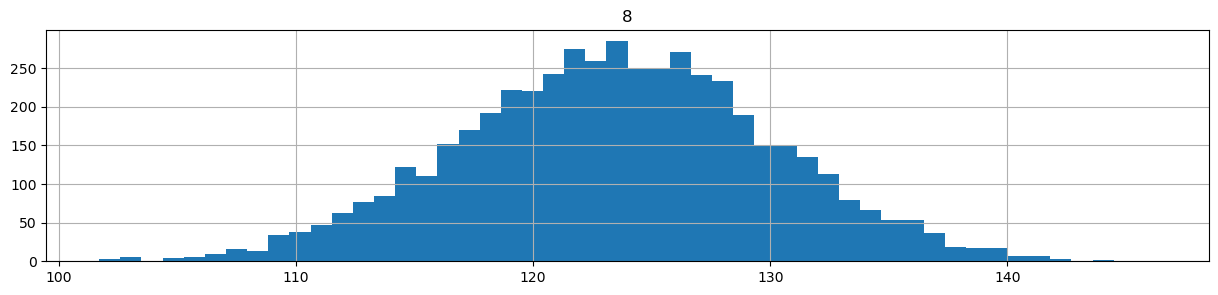

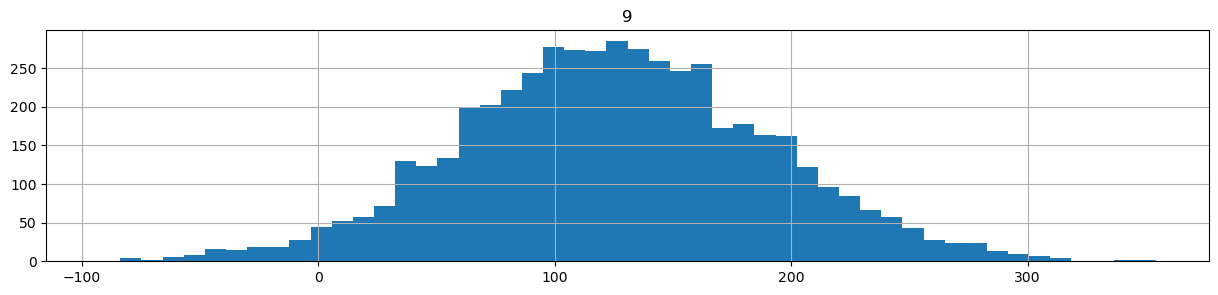

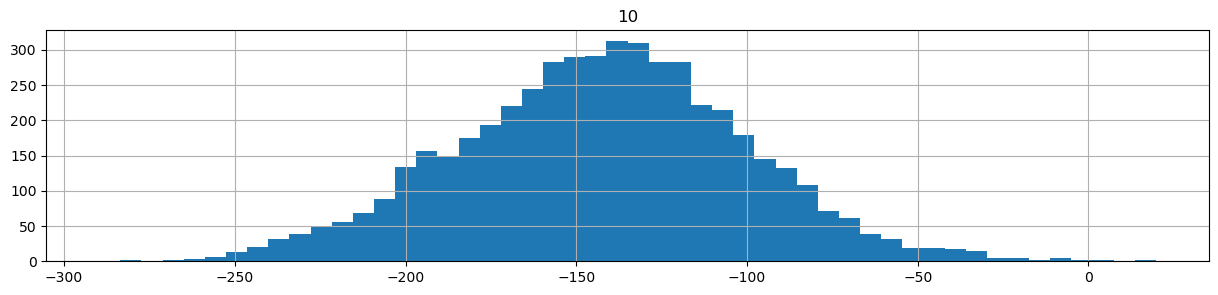

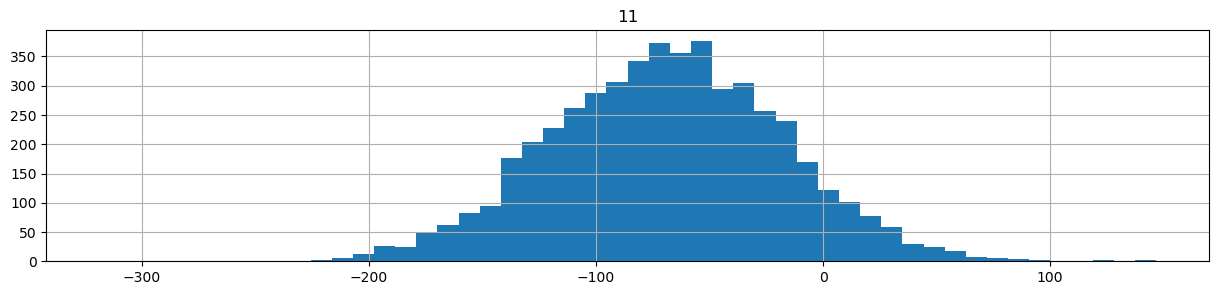

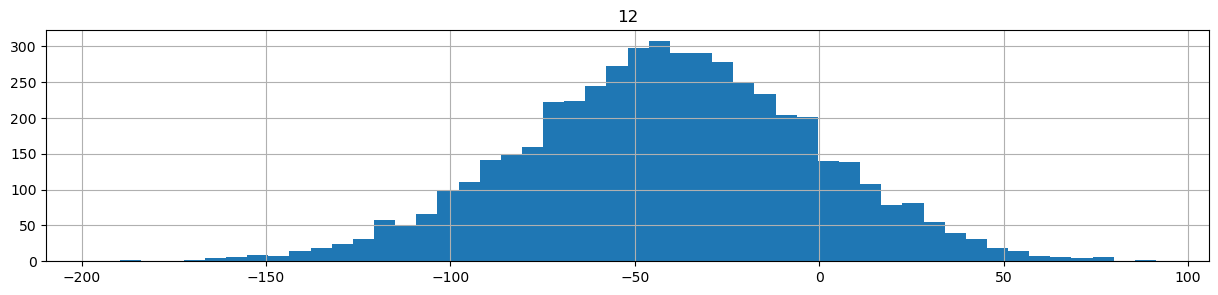

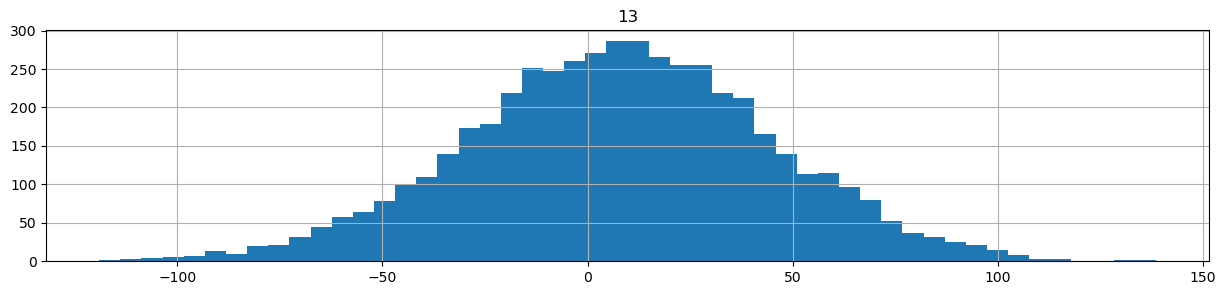

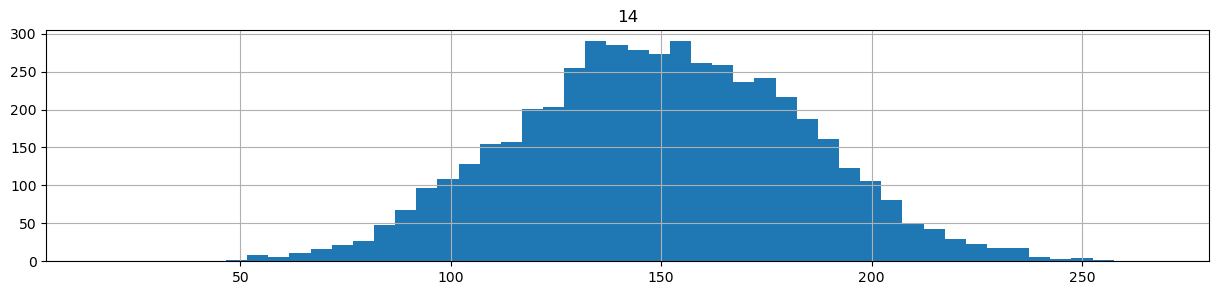

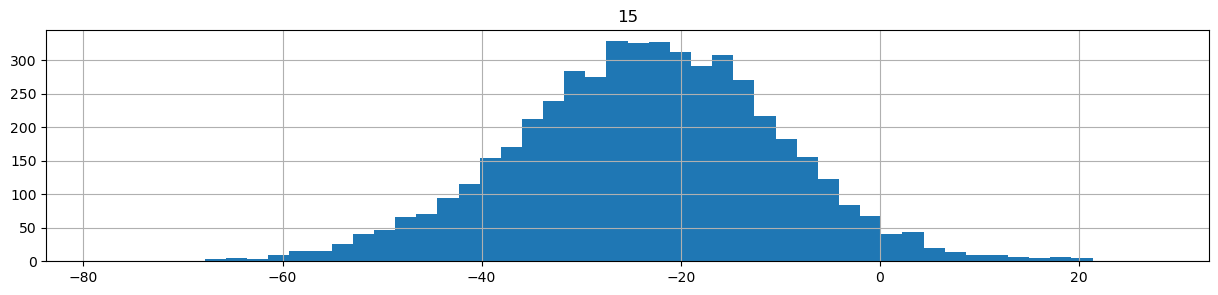

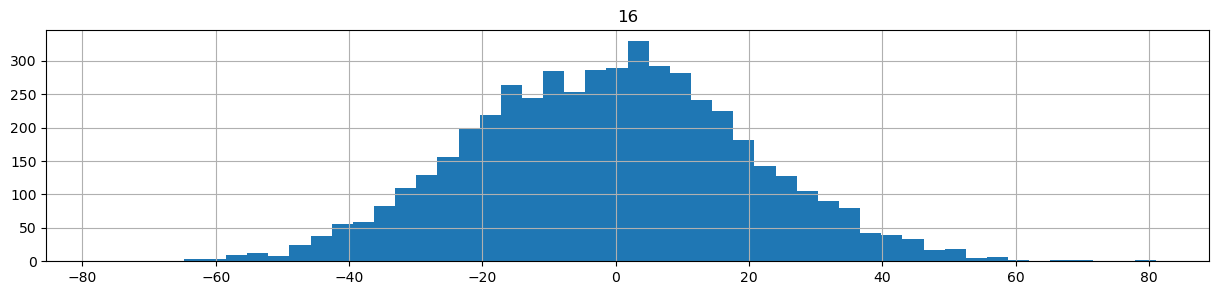

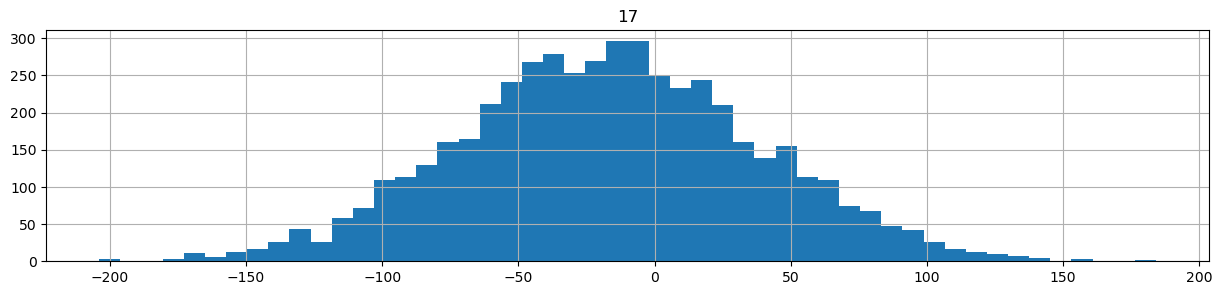

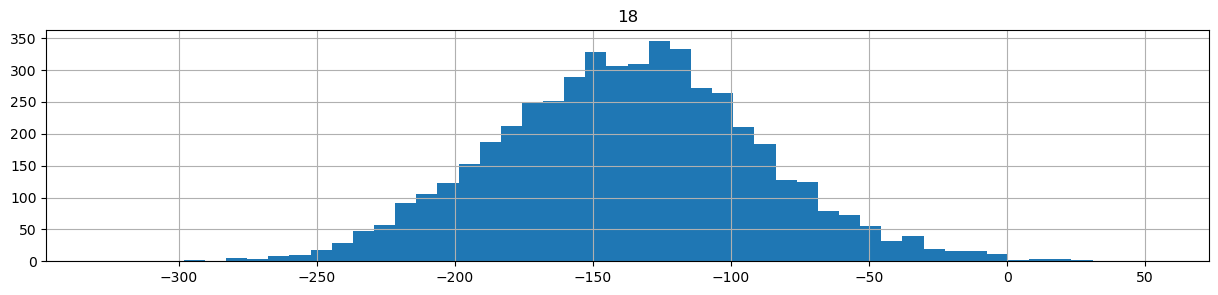

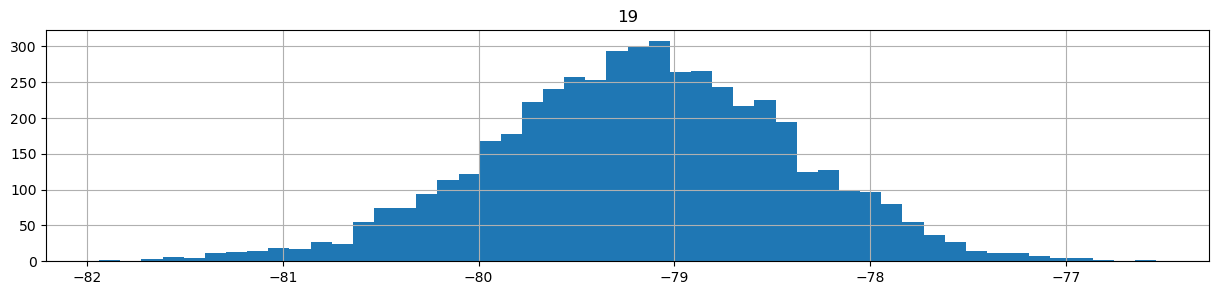

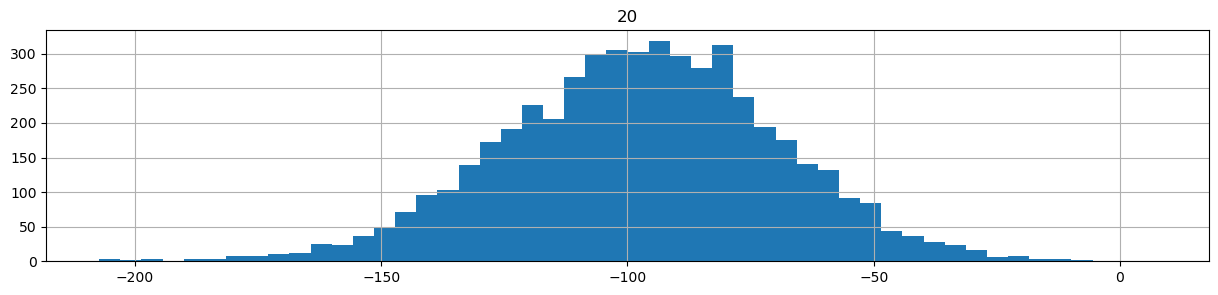

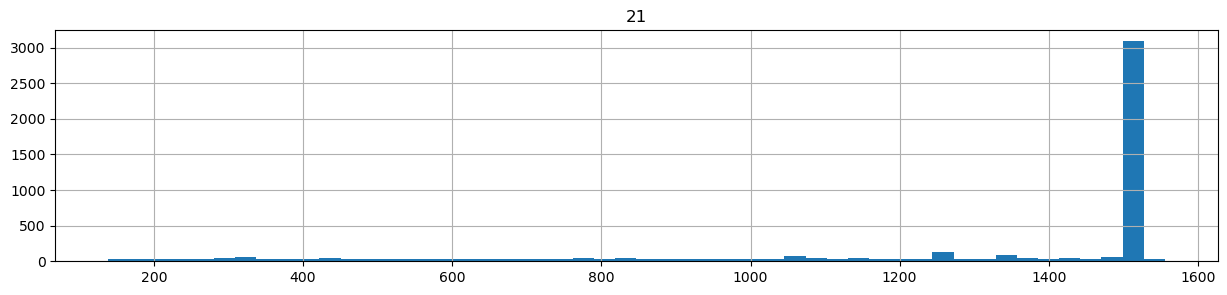

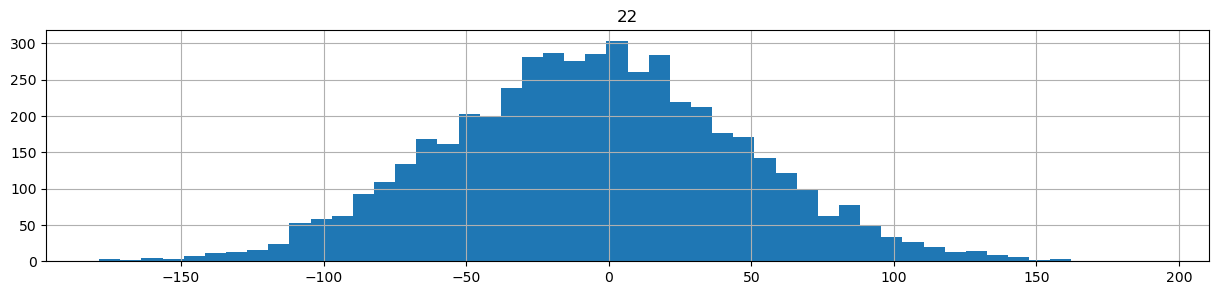

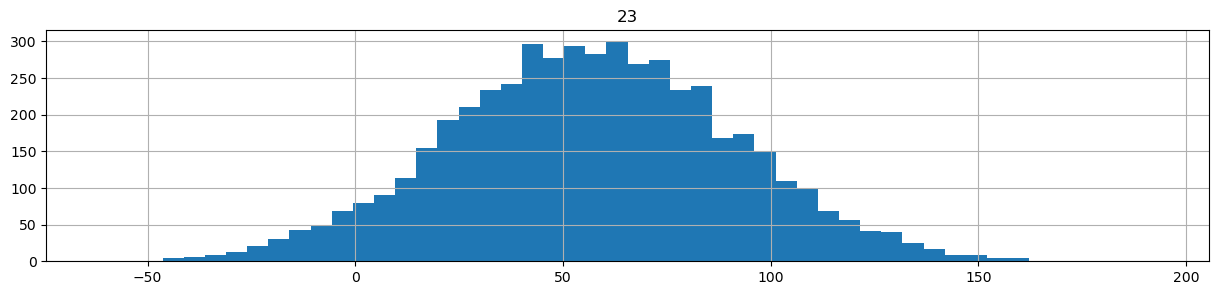

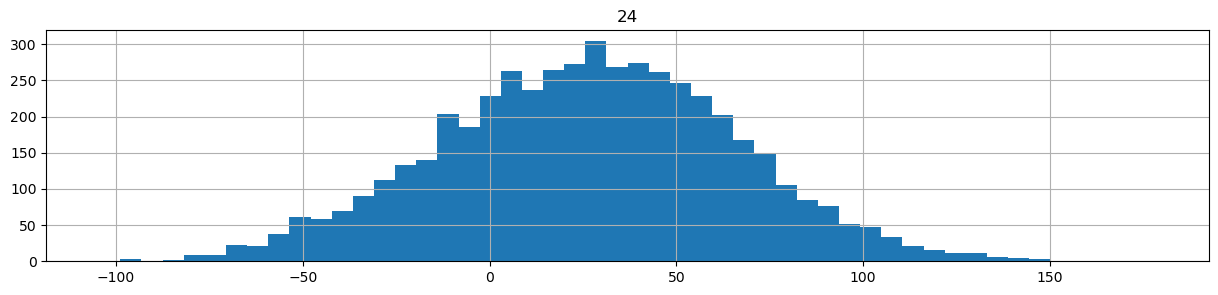

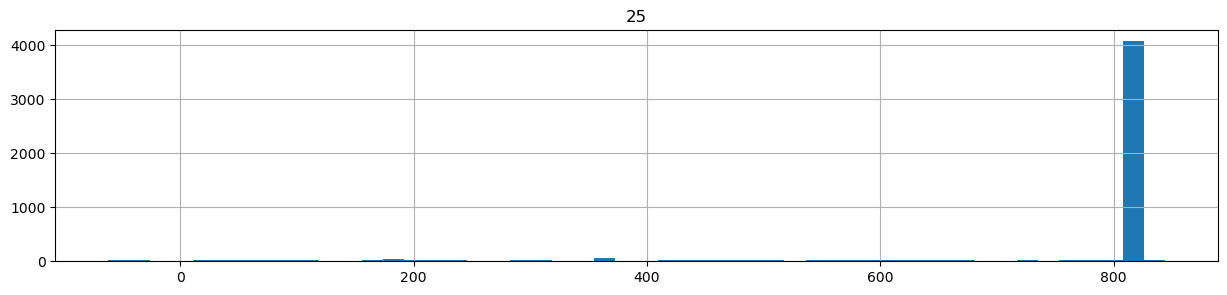

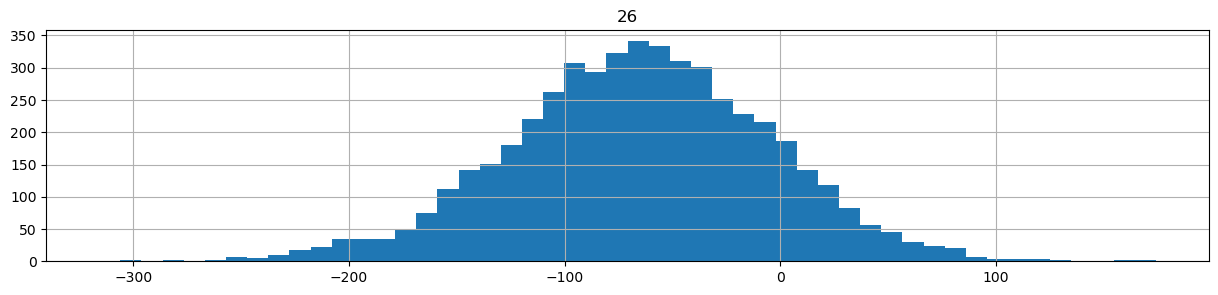

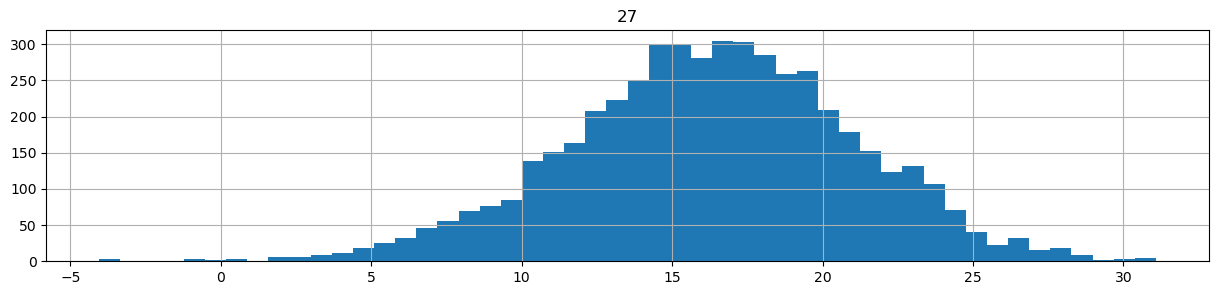

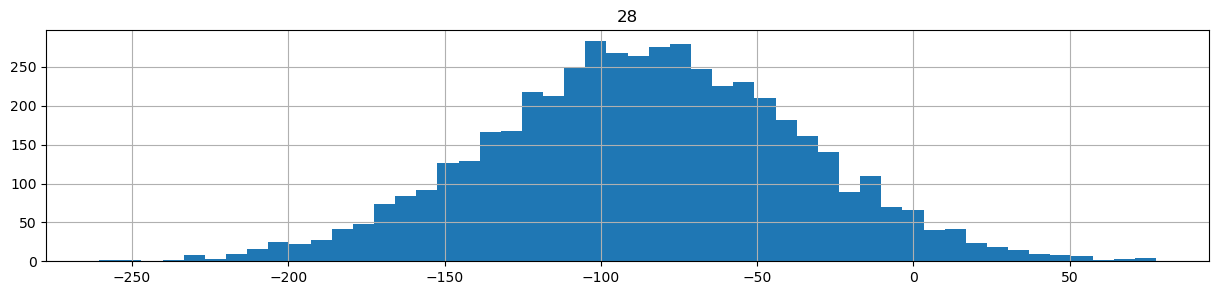

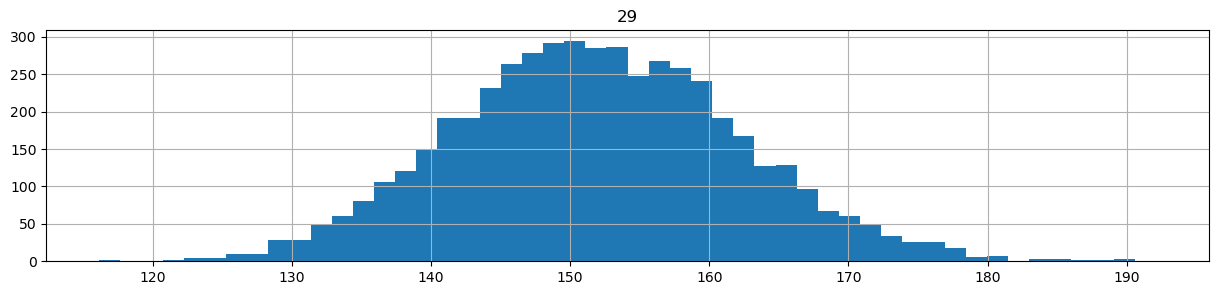

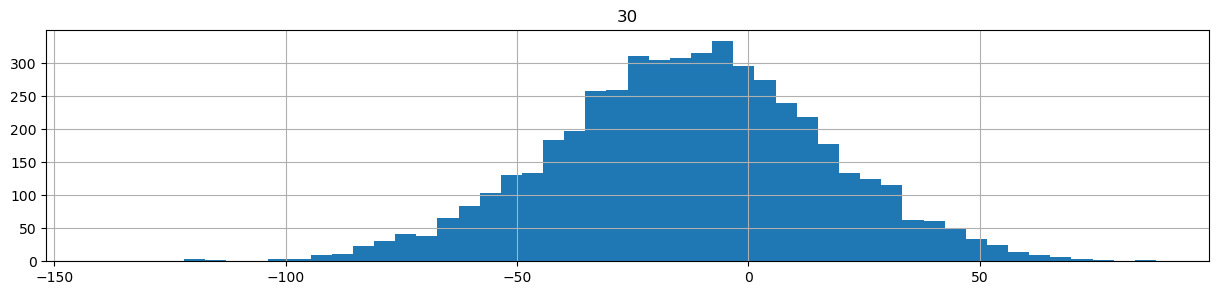

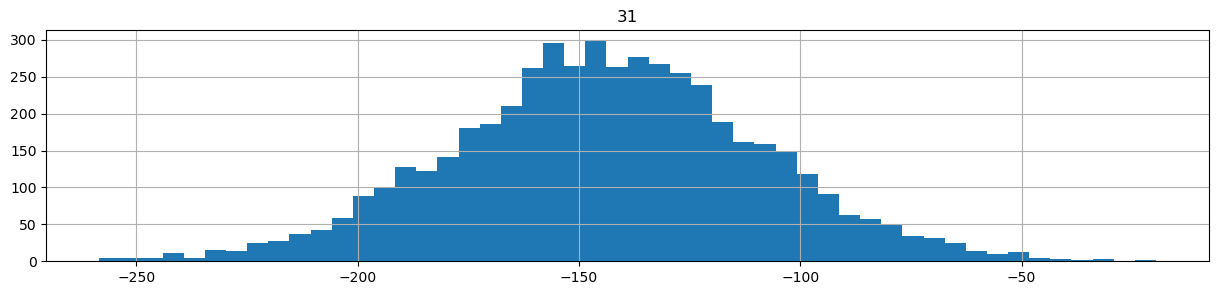

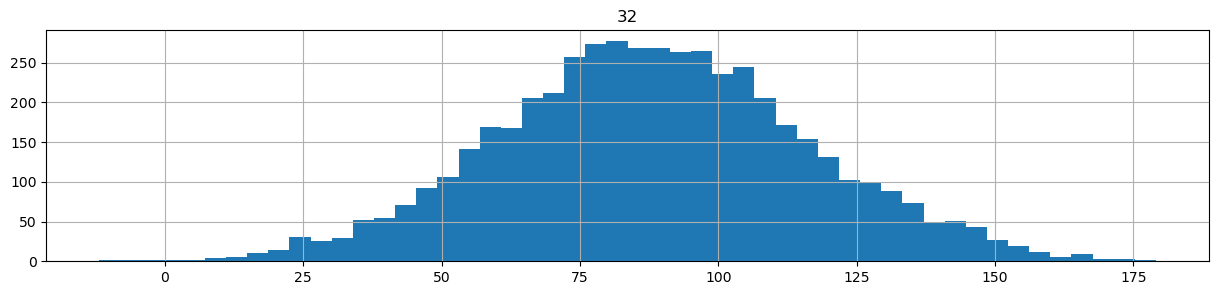

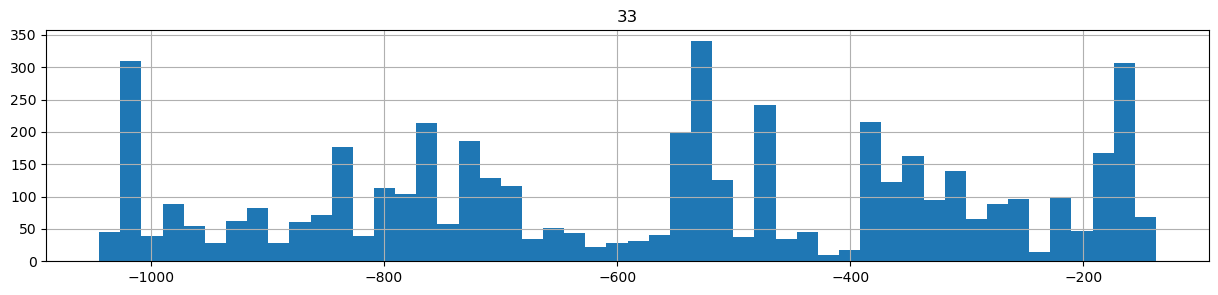

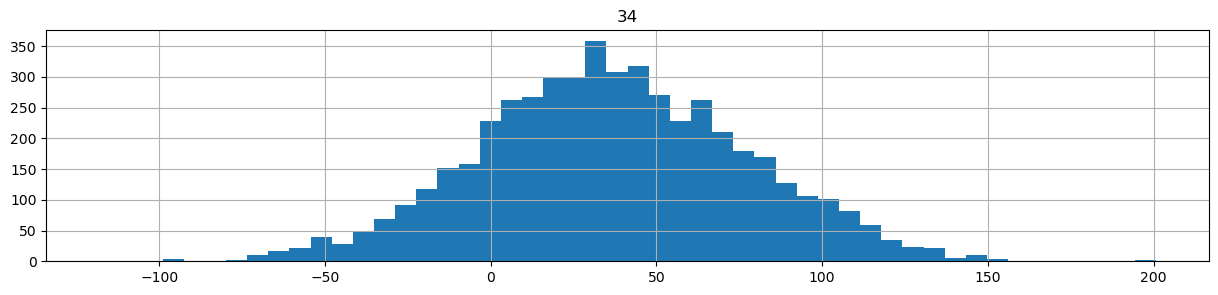

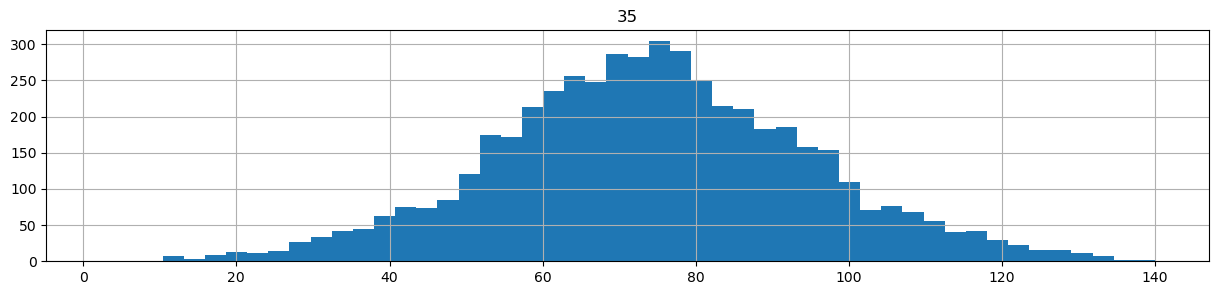

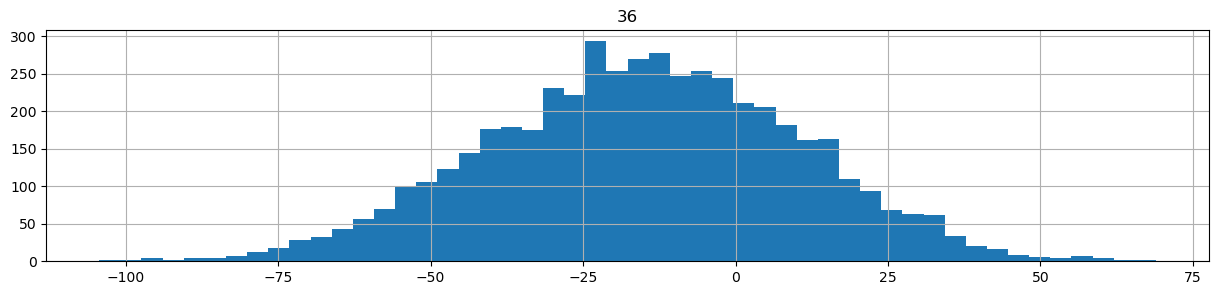

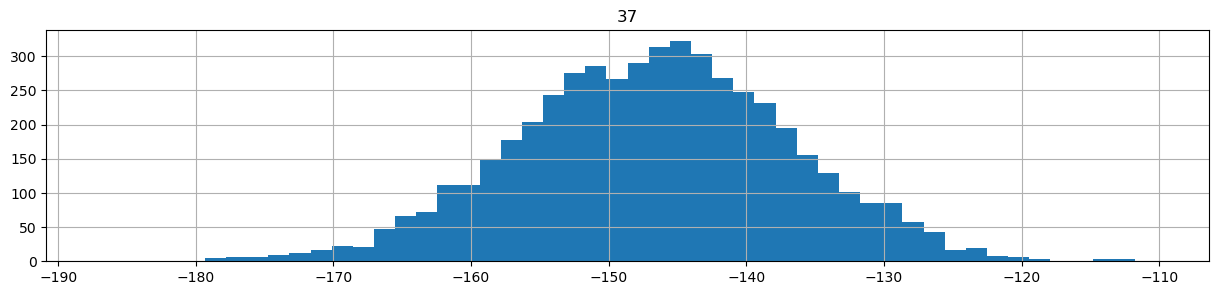

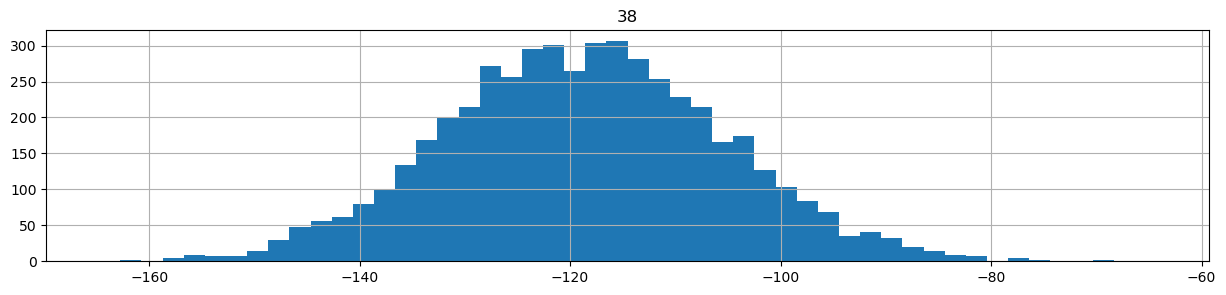

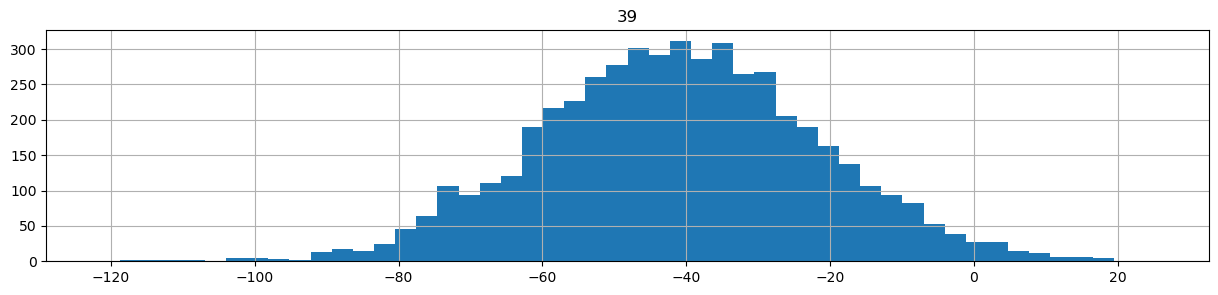

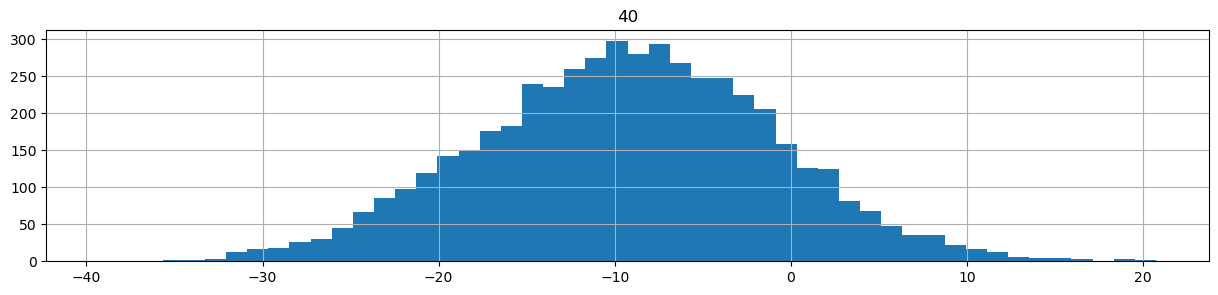

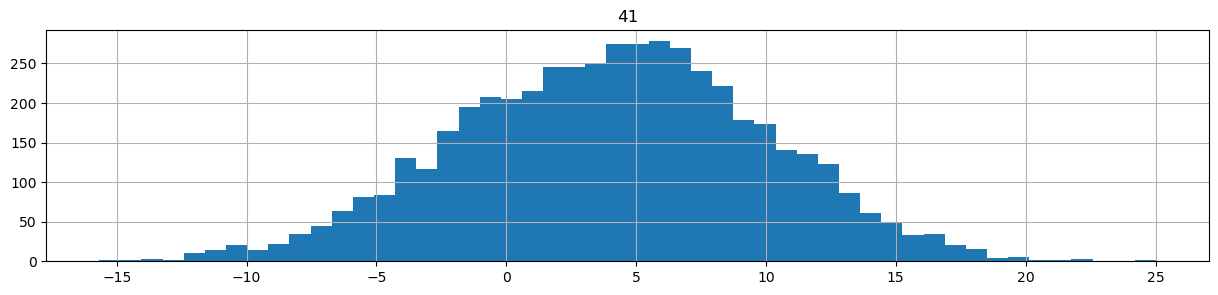

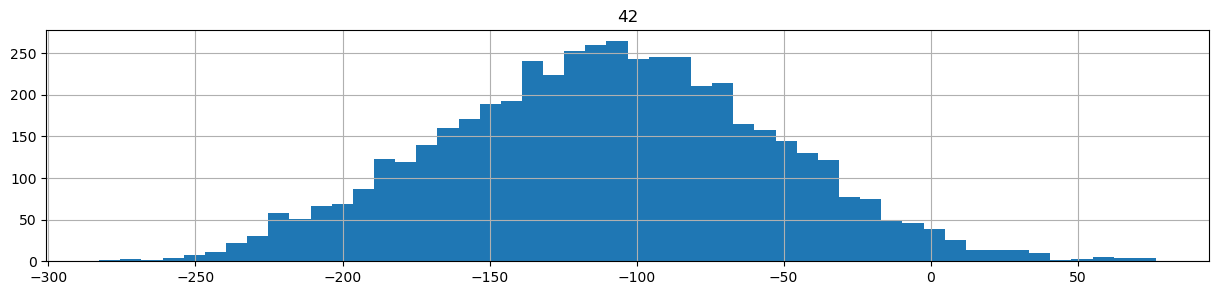

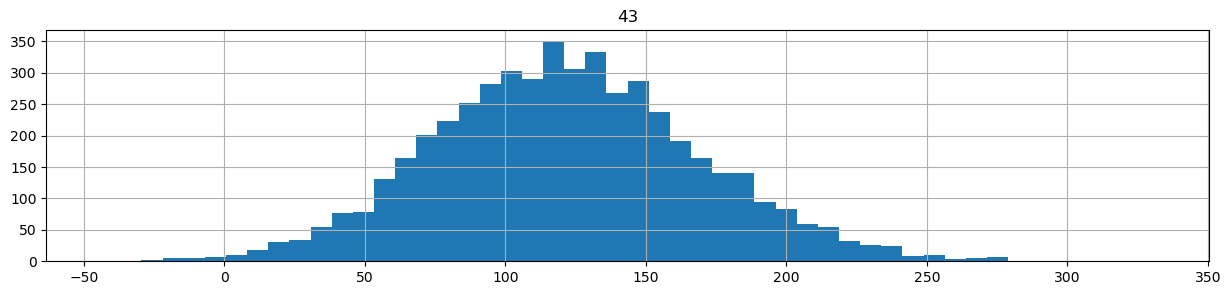

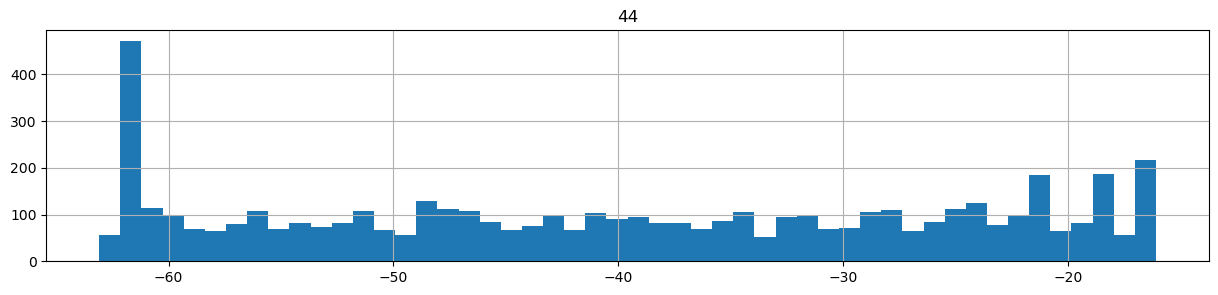

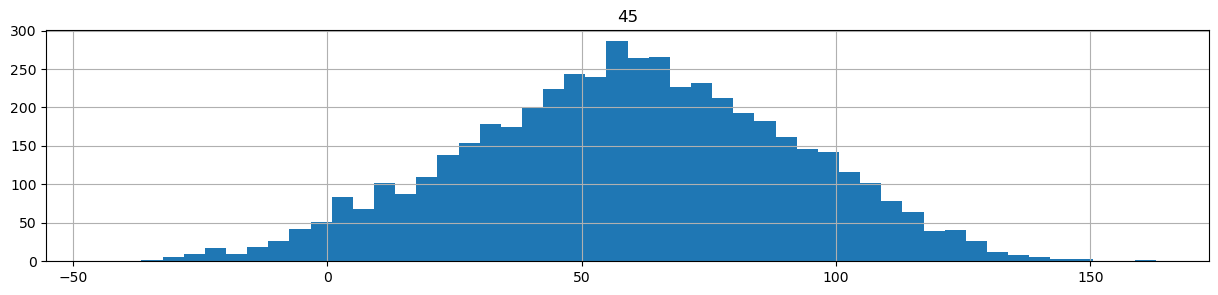

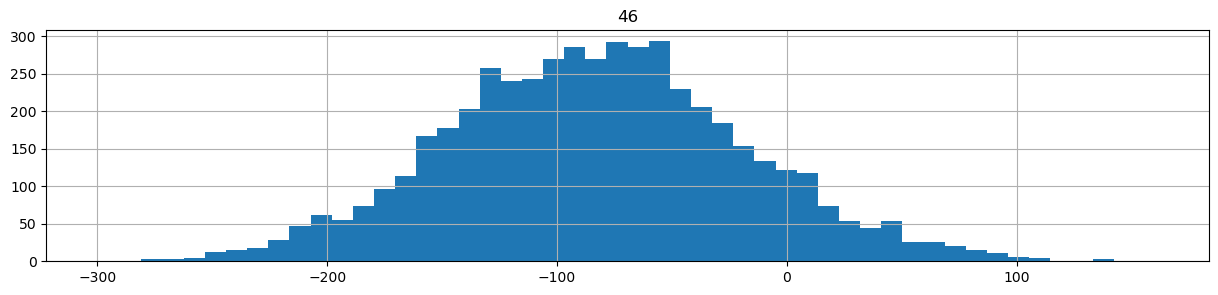

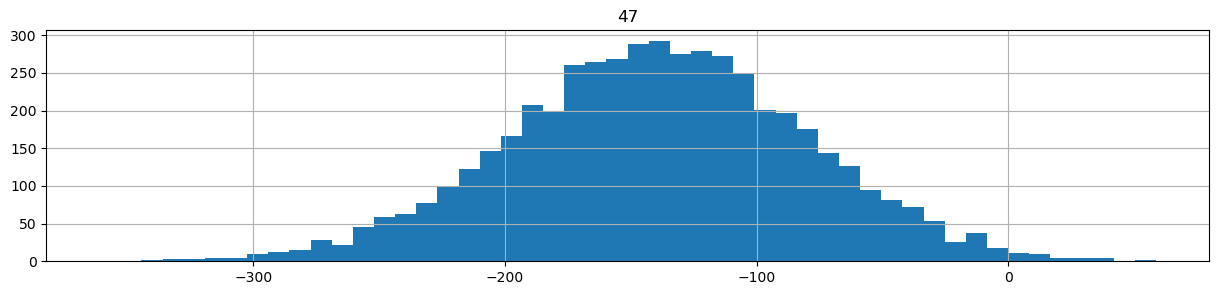

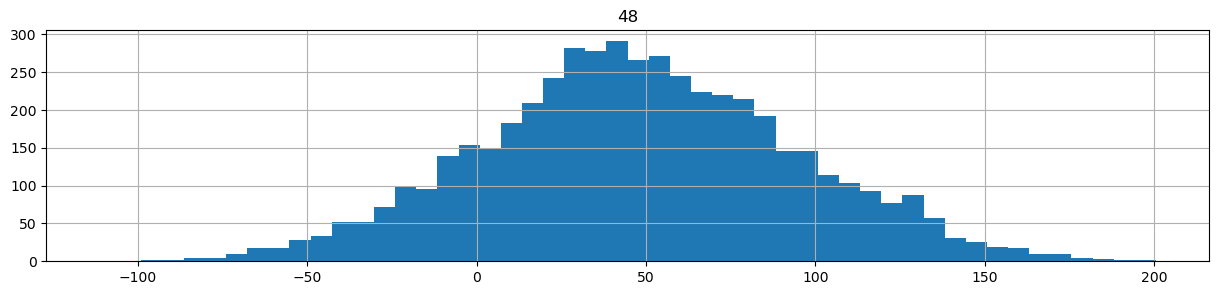

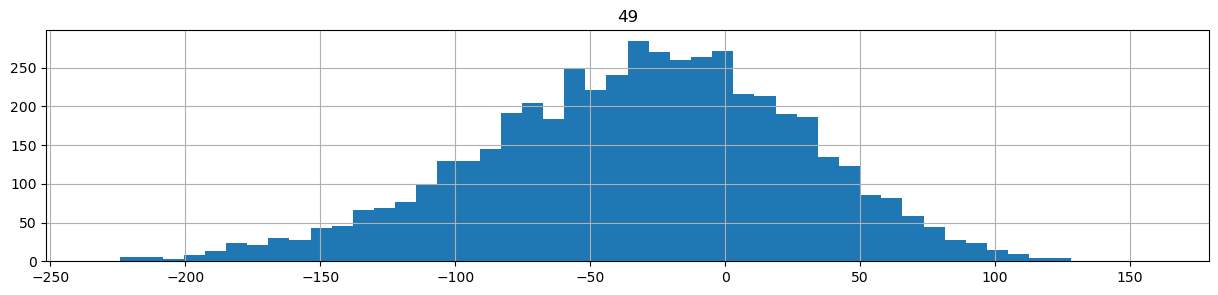

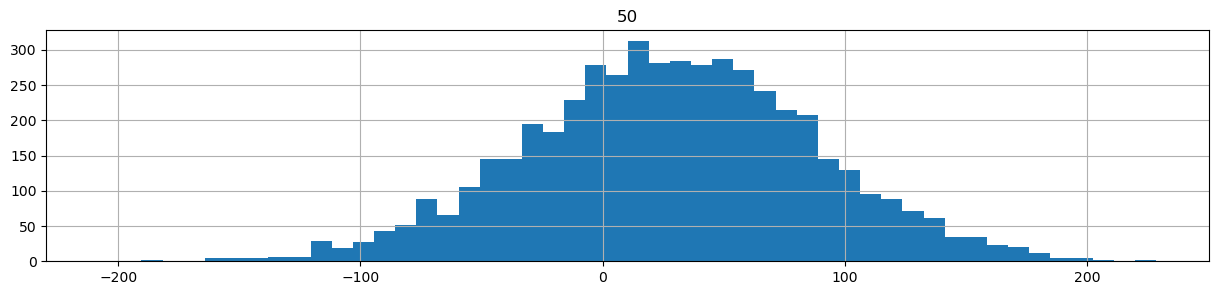

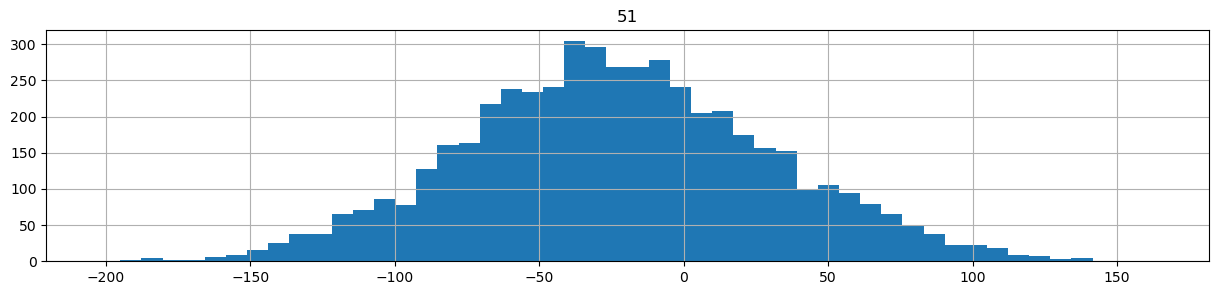

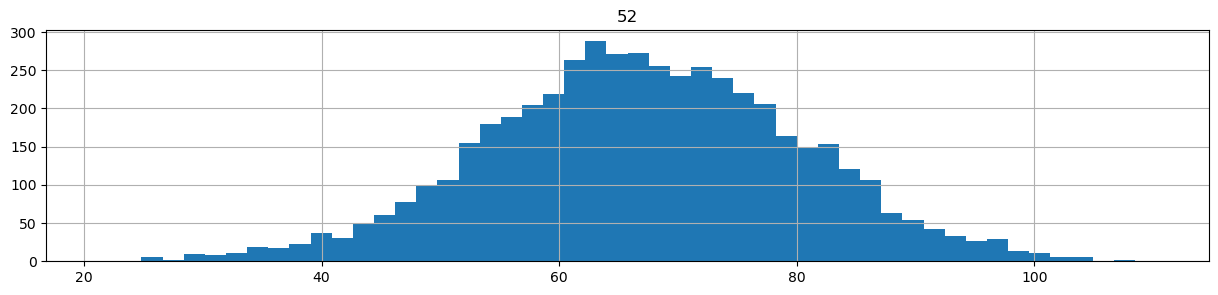

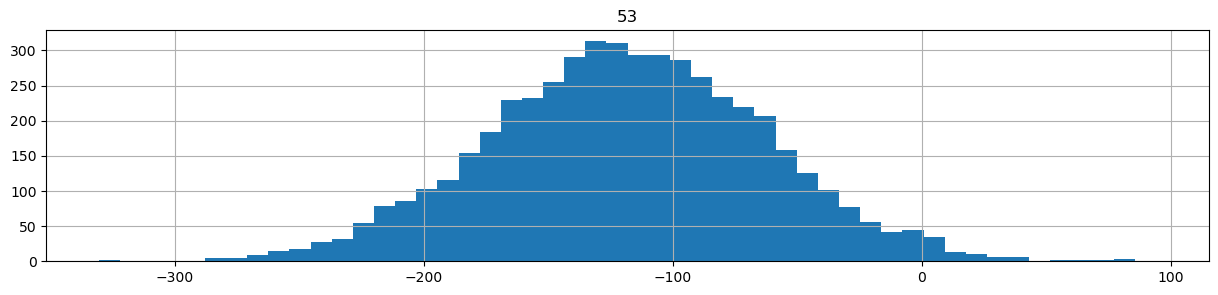

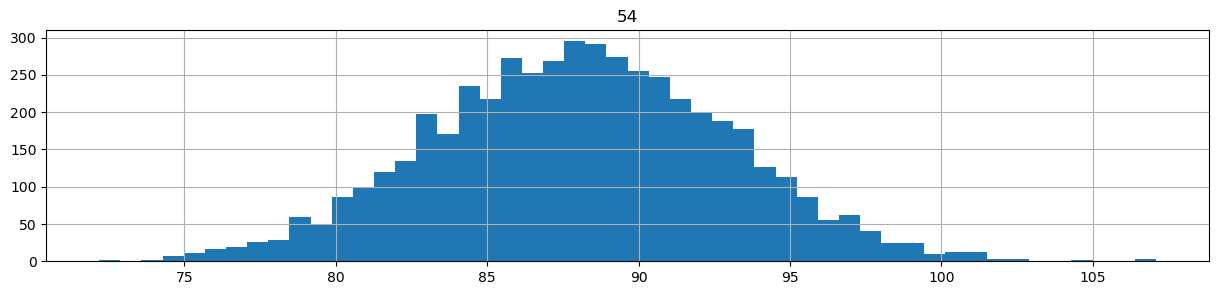

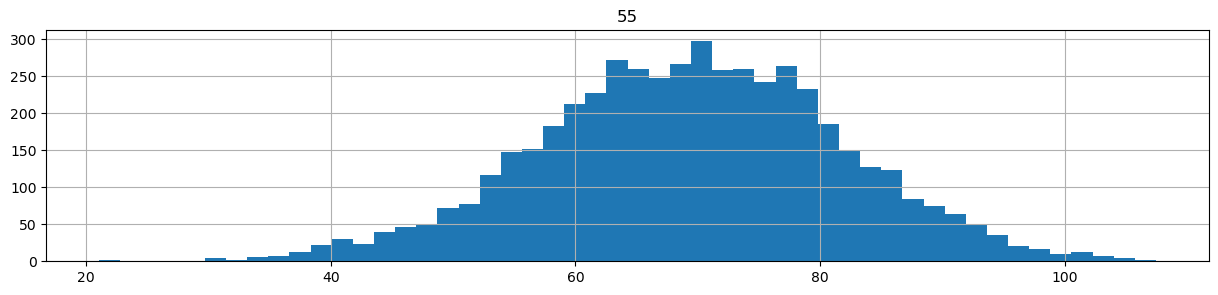

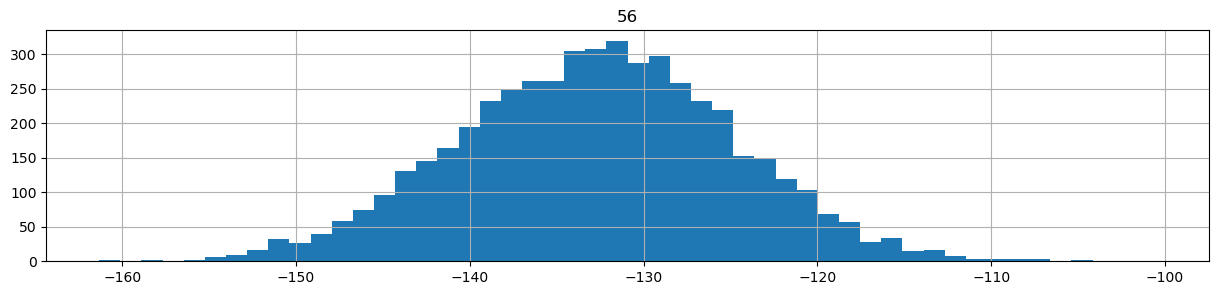

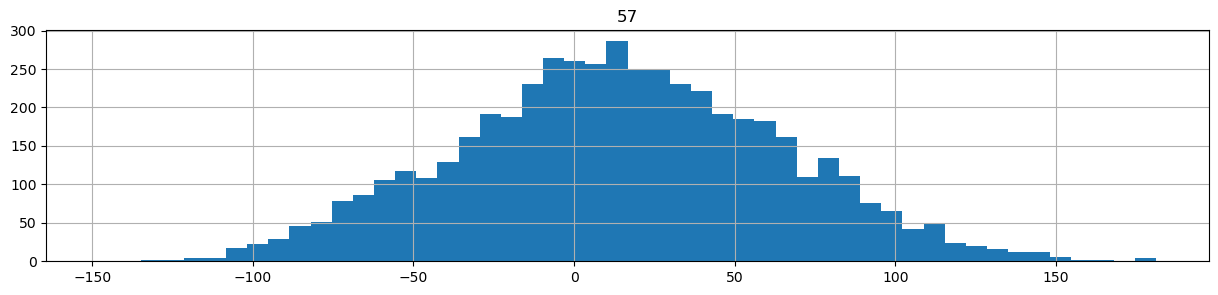

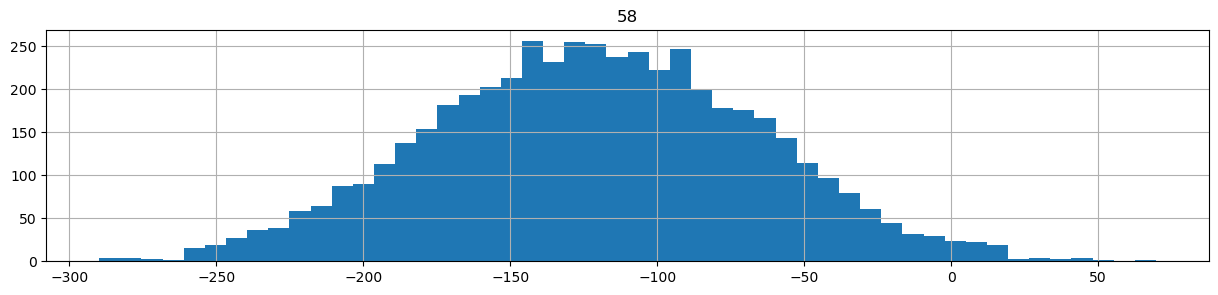

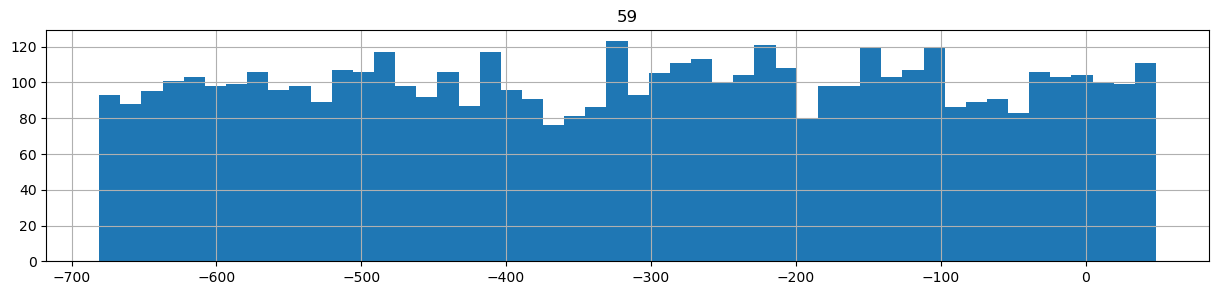

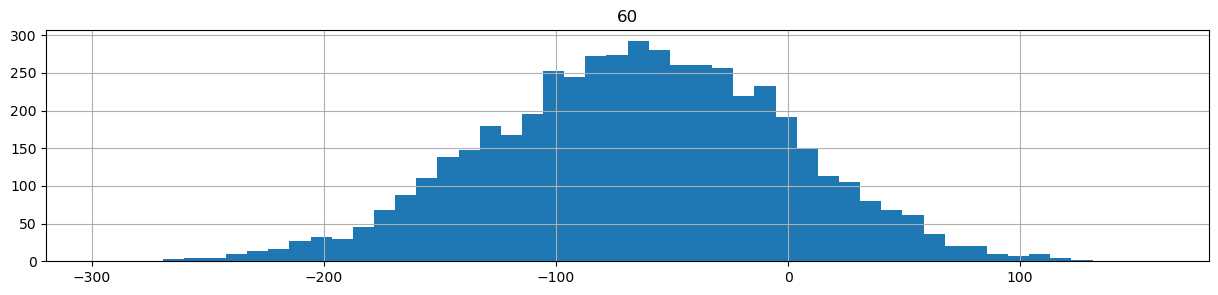

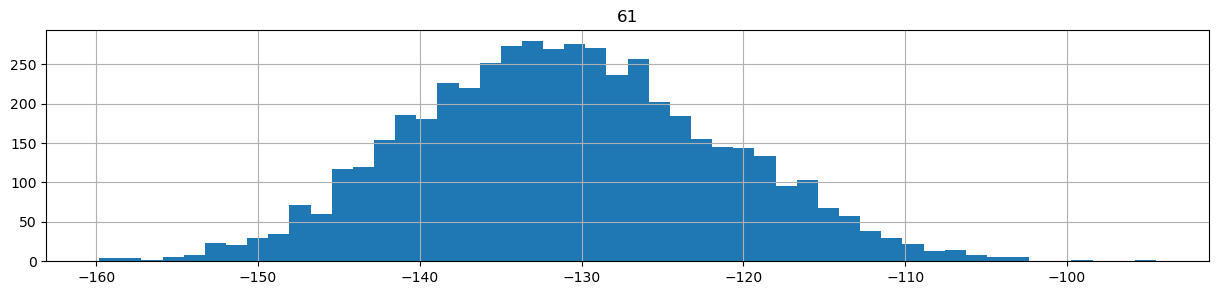

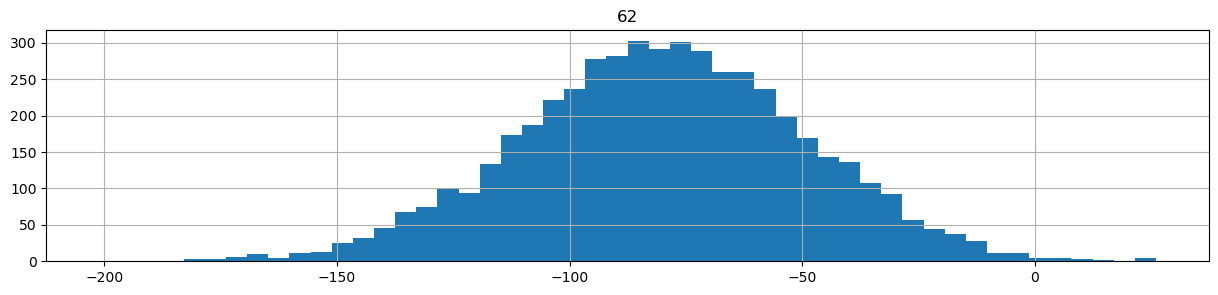

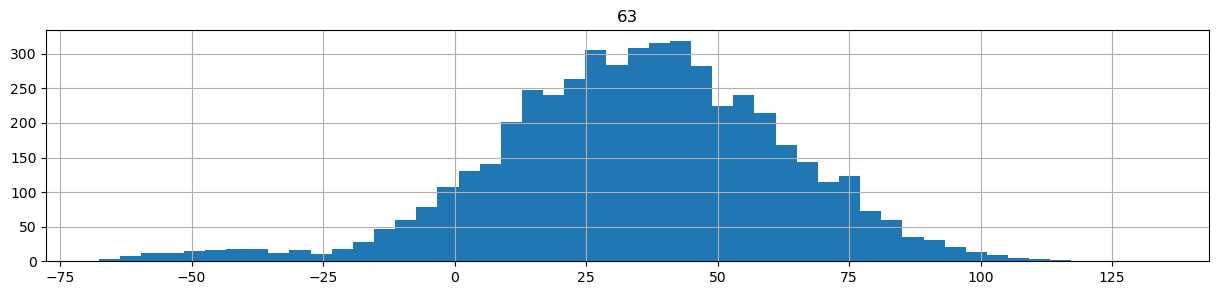

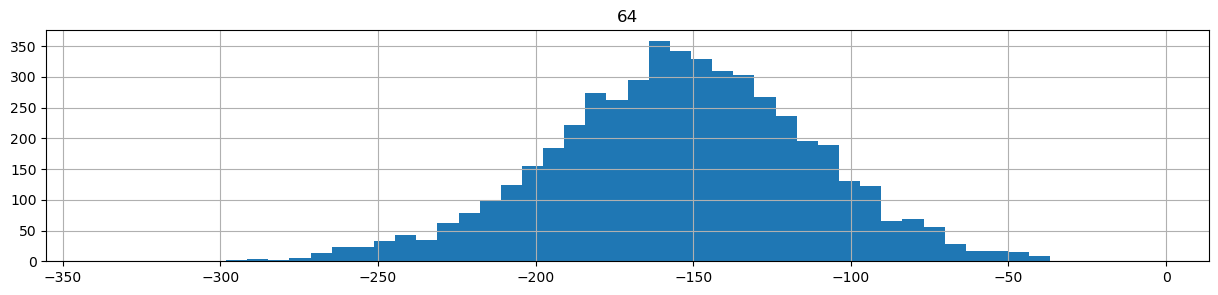

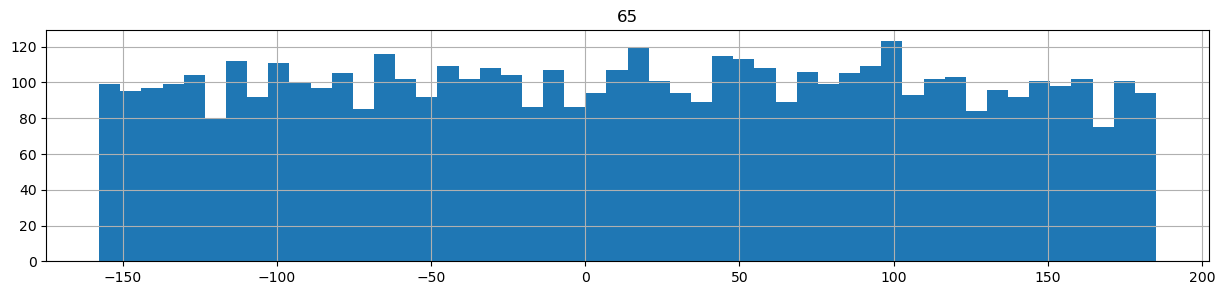

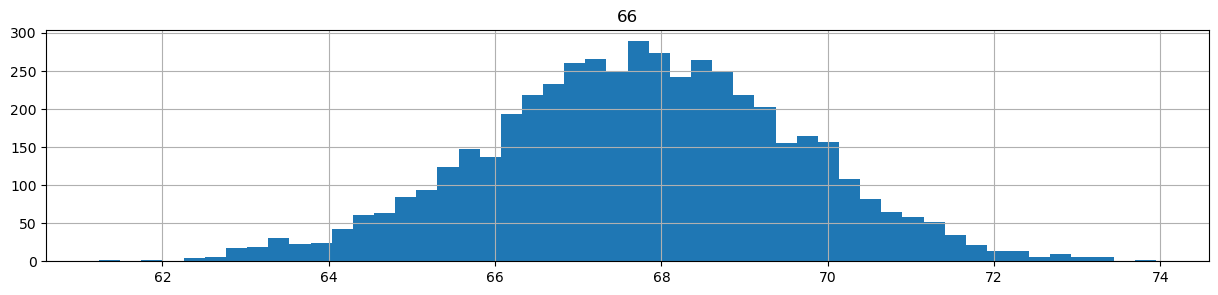

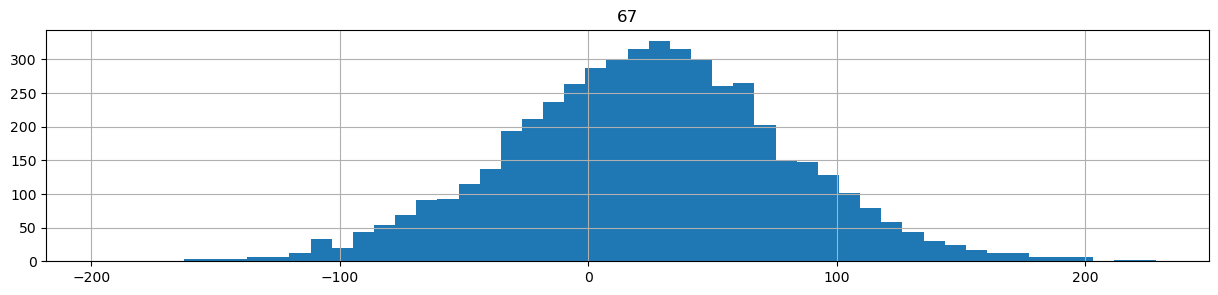

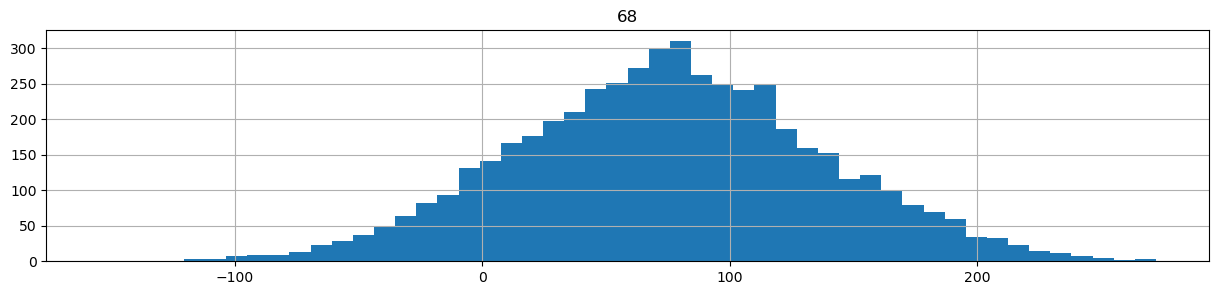

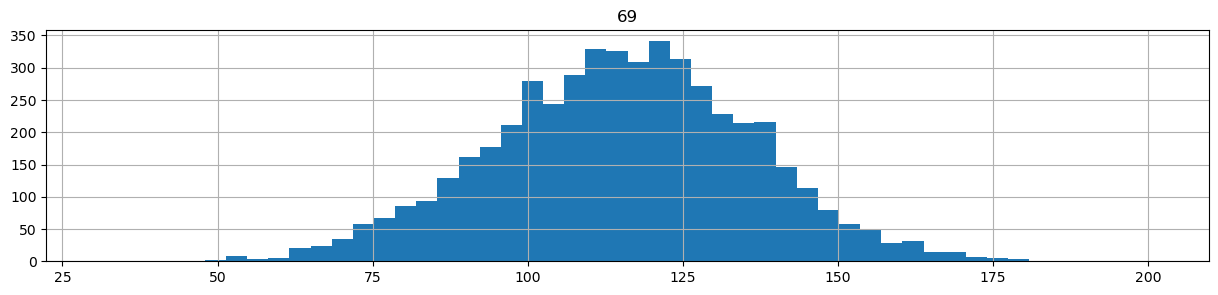

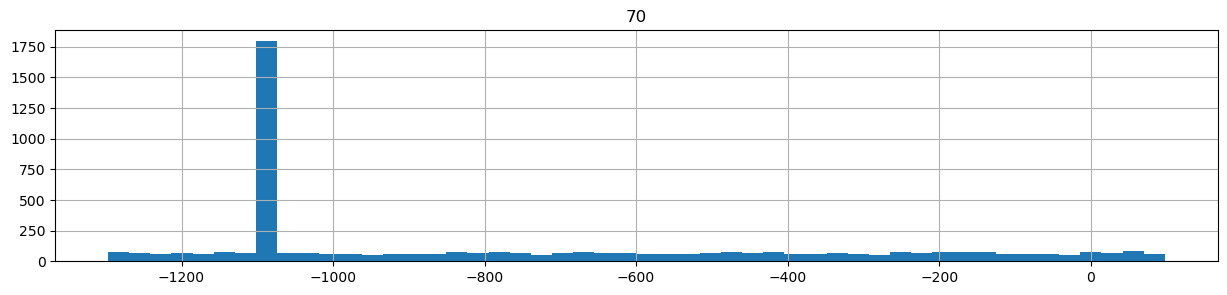

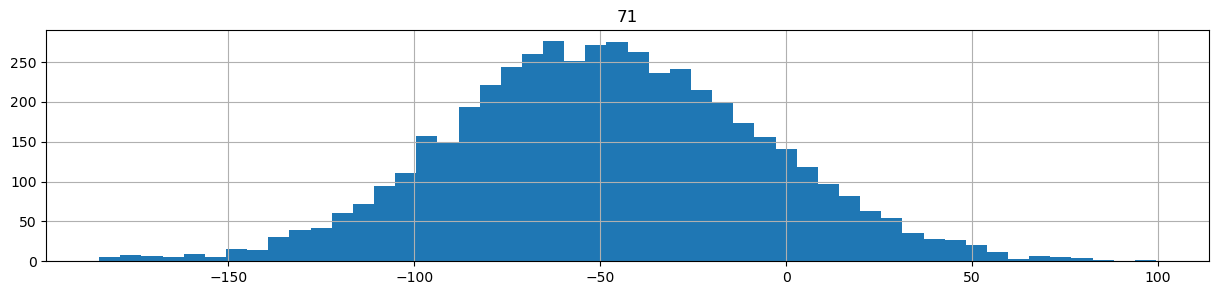

In [12]:
df_samples = df_base[:5000]
for c in df_samples.columns:
    plt.title(c)
    df_samples[c].hist(figsize=(15,3), bins=50);
    plt.show()

В основном признаки имеют нормальное распределение, кроме признаков '6', '21', '25', '33', '44', '59', '65', '70'.

Было попробовано удаление данных признаков, что привело к увеличению метрики с 63 до 70 процентов.

In [13]:
for df in [df_base, df_train, df_validation]:
    df.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)

Отмасштабируем данные при помощи StandardScaler().

In [14]:
scaler = StandardScaler()
df_base_scaler = scaler.fit_transform(df_base)
df_train_scaler = scaler.transform(df_train)
df_val_scaler = scaler.transform(df_validation)

Вывод:

В данных базового датасета не было найдено пропусков и дубликатов. В основном признаки базового датасета имеют нормальное распределение, кроме признаков '6', '21', '25', '33', '44', '59', '65', '70'. Данные признаки были удалены из базового, обучающего и валидационного датасета, что привело к увеличению метрики с 63 до 70 процентов. Также данные базового, обучающего и валидационного датасета были отмасштабированы при помощи StandardScaler().

## Разработка модели FAISS

Создадим idx_l2 или пространство векторов размерностью dims = 72, разделяемое на n_cells = 1708 кластеров (возьмем количество кластеров равным корню из количества векторов в базовом датасете) с помощью quantizer (квантователь: нужен для присвоения векторов определенному кластеру, использует метрику расстояния L2).

In [15]:
dims = df_base_scaler.shape[1]
n_cells = 1708

quantizer = faiss.IndexFlatL2(dims)

idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2 должен быть сначала обучен для создания 1708 кластеров, а затем векторы добавляются к этим кластерам. 

In [16]:
idx_l2.train(np.ascontiguousarray(df_base_scaler[:50000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base_scaler).astype('float32'))

Параметр nprobe указывает количество кластеров, которые необходимо посетить во время операции поиска.

In [17]:
idx_l2.nprobe = 25

Выполним поиск по idx_l2 5 похожих векторов для обучающего датасета, которые должны быть возвращены из посещенных кластеров. Операция поиска вернет идентификаторы 5 наиболее похожих векторов для каждого вектора запроса вместе с соответствующими расстояниями.


In [18]:
%%time
r_5_train, idx_5_train = idx_l2.search(np.ascontiguousarray(df_train_scaler).astype('float32'), 5)

CPU times: total: 6min 29s
Wall time: 52.5 s


Создадим base_index, который сопостовляет идентификатор из df_base индексам из df_base.

In [19]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Создадим функцию оценки качества алгоритма по метрике accuracy@5.

In [20]:
def acc_func(targets, idx, base_index):
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    print(100 * acc / len(idx))

Посчитаем accuracy@5 для обучающего датасета.

In [21]:
acc_func(targets, idx_5_train, base_index)

70.179


Accuracy@5 для обучающего датасета равняется 70.179

Выполним поиск по idx_l2 5 похожих векторов для валидационного датасета.

In [22]:
%%time
r_5_valid, idx_5_valid = idx_l2.search(np.ascontiguousarray(df_val_scaler).astype('float32'), 5)

CPU times: total: 6min 26s
Wall time: 52.1 s


Посчитаем accuracy@5 для валидационного датасета.

In [23]:
acc_func(df_validation_answer['Expected'], idx_5_valid, base_index)

70.129


Accuracy@5 для валидационного датасета равняется 70.179

Вывод:

Был создан idx_l2 или пространство векторов размерностью dims = 72, разделяемое на n_cells = 1708 кластеров (количество кластеров равно корню из количества векторов в базовом датасете) с помощью quantizer (квантователь: нужен для присвоения векторов определенному кластеру, использует метрику расстояния L2). 

idx_l2 был сначала обучен для создания 1708 кластеров, а затем векторы были добавлены к этим кластерам. 

Был настроен параметр nprobe, который указывает количество кластеров, которые необходимо посетить во время операции поиска.

Был выполнен поиск по idx_l2 5 похожих векторов для обучающего датасета, в итоге было получено Accuracy@5 для обучающего датасета равное 70.179.

Был выполнен поиск по idx_l2 5 похожих векторов для валидационного датасета, в итоге было получено Accuracy@5 для валидационного датасета равное 70.179.

## Разработка модели FAISS + CatBoostClassifier

Выполним поиск по idx_l2 50 похожих векторов для обучающего датасета.

In [24]:
num_id = 50

In [25]:
%%time
r_50_train, idx_50_train = idx_l2.search(np.ascontiguousarray(df_train_scaler).astype('float32'), num_id)

CPU times: total: 6min 28s
Wall time: 52.8 s


Выполним поиск по idx_l2 50 похожих векторов для валидационного датасета.

In [26]:
%%time
r_50_valid, idx_50_valid = idx_l2.search(np.ascontiguousarray(df_val_scaler).astype('float32'), num_id)

CPU times: total: 6min 27s
Wall time: 53.3 s


Создадим функцию конвертации индексов в идентификаторы базового датасета.

In [27]:
def convert_index_func(base_id):
    return base_index[base_id]

Создадим функцию создания датасета для обучения CatBoostClassifier и датасета для последующих предсказаний, состоящих из векторов двойной длины (каждому вектору обучающей или валидационной выборки соответсвует 50 найденных векторов из базового датасета) 

In [28]:
def gen_df_for_cbc(idx_50_train, targets, df_train, df_base):
    df_for_cbc = pd.DataFrame(data=idx_50_train, index=df_train.index)
    df_for_cbc = pd.melt(df_for_cbc.T)
    df_for_cbc.columns = ['query_id', 'base_id']
    df_for_cbc['base_id'] = df_for_cbc['base_id'].apply(convert_index_func)    
    df_for_cbc = df_for_cbc.merge(targets, how='left', left_on='query_id', right_on='Id')
    df_for_cbc.rename(columns = {'Target':'train_id', 'Expected':'valid_id'}, inplace=True)
    df_for_cbc = df_for_cbc.merge(df_base, how='left', left_on='base_id', right_on='Id')
    df_for_cbc = df_for_cbc.merge(df_train, how='left', left_on='query_id', right_on='Id')
    return df_for_cbc

Получим обучающий датасет для CatBoostClassifier, а также создадим столбец таргетов (если индексы базового датасета и обучающего совпадают, то 1, иначе 0).

In [29]:
%%time
df_for_cbc_train = gen_df_for_cbc(idx_50_train, targets, df_train, df_base)
df_for_cbc_train['target'] = (df_for_cbc_train['train_id'] == df_for_cbc_train['base_id']).astype('int')
df_for_cbc_train

CPU times: total: 33.7 s
Wall time: 39 s


,query_id,base_id,train_id,0_x,1_x,2_x,3_x,4_x,5_x,7_x,...,61_y,62_y,63_y,64_y,66_y,67_y,68_y,69_y,71_y,target
0,0-query,361564-base,675816-base,-60.221460,17.415554,-44.884090,-187.29471,177.27692,-79.936890,50.207900,...,-132.38617,-105.42782,70.107360,-155.80257,65.90379,34.457500,62.642094,134.76360,-25.958572,0
1,0-query,1375561-base,675816-base,-58.357925,18.708204,-46.583763,-180.11511,159.21982,-80.447710,71.515220,...,-132.38617,-105.42782,70.107360,-155.80257,65.90379,34.457500,62.642094,134.76360,-25.958572,0
2,0-query,2515747-base,675816-base,-69.175125,16.137346,-55.946490,-181.76881,165.82039,-84.546930,79.091700,...,-132.38617,-105.42782,70.107360,-155.80257,65.90379,34.457500,62.642094,134.76360,-25.958572,0
3,0-query,530165-base,675816-base,-67.476746,18.619154,-53.327007,-181.73401,178.88336,-86.005035,47.028890,...,-132.38617,-105.42782,70.107360,-155.80257,65.90379,34.457500,62.642094,134.76360,-25.958572,0
4,0-query,244376-base,675816-base,-70.620514,17.467127,-55.683983,-175.97879,164.55058,-76.327350,60.030160,...,-132.38617,-105.42782,70.107360,-155.80257,65.90379,34.457500,62.642094,134.76360,-25.958572,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,99999-query,1545221-base,2769109-base,-61.306180,11.467062,-15.665707,-164.80795,157.02785,-74.430800,23.089804,...,-148.16771,-81.33553,5.184549,-134.78845,66.88463,45.619125,129.991240,100.65671,-80.152910,0
4999996,99999-query,1886469-base,2769109-base,-45.798080,7.995006,-31.697956,-155.29422,151.16458,-86.178230,44.803170,...,-148.16771,-81.33553,5.184549,-134.78845,66.88463,45.619125,129.991240,100.65671,-80.152910,0
4999997,99999-query,649110-base,2769109-base,-76.036606,9.190182,-48.933640,-139.37193,129.27893,-95.063660,57.064186,...,-148.16771,-81.33553,5.184549,-134.78845,66.88463,45.619125,129.991240,100.65671,-80.152910,0
4999998,99999-query,68004-base,2769109-base,-48.880184,13.427591,-46.257442,-150.38165,108.18257,-85.488370,-26.917059,...,-148.16771,-81.33553,5.184549,-134.78845,66.88463,45.619125,129.991240,100.65671,-80.152910,0


Посмотрим на баланс классов.

In [30]:
df_for_cbc_train['target'].value_counts()

0    4922805
1      77195
Name: target, dtype: int64

В данных для обучения CatBoostClassifier имеется сильный дисбаланс классов.

Разделим обучающий датасет для CatBoostClassifier на тагреты и признаки.

In [31]:
target_for_cbc_train = df_for_cbc_train['target']
features_for_cbc_train = df_for_cbc_train.drop(['base_id', 'train_id', 'query_id', 'target'], axis=1)

Создадим пайплайн, включающий StandardScaler() для масштабирования данных и CatBoostClassifier() с параметрами: время обучения = 0.2 и глубина = 6.

In [58]:
cbc = make_pipeline(StandardScaler(),
                    CatBoostClassifier(random_state=13,
                                       learning_rate=0.2,
                                       depth=6))
cbc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001D6AA2D1CF0>)])

Обучим CatBoostClassifier().

In [59]:
%%time
cbc.fit(features_for_cbc_train, target_for_cbc_train)

0:	learn: 0.3740945	total: 1.57s	remaining: 26m 14s
1:	learn: 0.2250645	total: 3.27s	remaining: 27m 10s
2:	learn: 0.1524220	total: 4.81s	remaining: 26m 38s
3:	learn: 0.1179850	total: 6.3s	remaining: 26m 9s
4:	learn: 0.0992007	total: 7.69s	remaining: 25m 29s
5:	learn: 0.0885577	total: 9.38s	remaining: 25m 53s
6:	learn: 0.0818115	total: 11.3s	remaining: 26m 48s
7:	learn: 0.0782669	total: 12.7s	remaining: 26m 20s
8:	learn: 0.0758573	total: 14.3s	remaining: 26m 12s
9:	learn: 0.0737055	total: 16.1s	remaining: 26m 34s
10:	learn: 0.0723774	total: 17.5s	remaining: 26m 17s
11:	learn: 0.0710803	total: 19.5s	remaining: 26m 45s
12:	learn: 0.0698693	total: 21.4s	remaining: 27m 8s
13:	learn: 0.0687873	total: 23.7s	remaining: 27m 46s
14:	learn: 0.0678803	total: 25.6s	remaining: 28m 1s
15:	learn: 0.0671387	total: 27.5s	remaining: 28m 9s
16:	learn: 0.0661887	total: 29.9s	remaining: 28m 48s
17:	learn: 0.0654825	total: 31.5s	remaining: 28m 40s
18:	learn: 0.0648784	total: 33.5s	remaining: 28m 47s
19:	lear

153:	learn: 0.0432535	total: 4m 21s	remaining: 23m 56s
154:	learn: 0.0432025	total: 4m 23s	remaining: 23m 56s
155:	learn: 0.0431730	total: 4m 24s	remaining: 23m 53s
156:	learn: 0.0431400	total: 4m 26s	remaining: 23m 49s
157:	learn: 0.0431159	total: 4m 27s	remaining: 23m 45s
158:	learn: 0.0430943	total: 4m 28s	remaining: 23m 41s
159:	learn: 0.0430432	total: 4m 30s	remaining: 23m 40s
160:	learn: 0.0430248	total: 4m 32s	remaining: 23m 37s
161:	learn: 0.0429975	total: 4m 33s	remaining: 23m 32s
162:	learn: 0.0429675	total: 4m 34s	remaining: 23m 29s
163:	learn: 0.0429274	total: 4m 36s	remaining: 23m 28s
164:	learn: 0.0428782	total: 4m 38s	remaining: 23m 28s
165:	learn: 0.0428362	total: 4m 39s	remaining: 23m 26s
166:	learn: 0.0427852	total: 4m 42s	remaining: 23m 26s
167:	learn: 0.0427346	total: 4m 43s	remaining: 23m 24s
168:	learn: 0.0426864	total: 4m 45s	remaining: 23m 23s
169:	learn: 0.0426464	total: 4m 47s	remaining: 23m 22s
170:	learn: 0.0426192	total: 4m 48s	remaining: 23m 18s
171:	learn

304:	learn: 0.0397886	total: 8m	remaining: 18m 15s
305:	learn: 0.0397704	total: 8m 2s	remaining: 18m 14s
306:	learn: 0.0397615	total: 8m 3s	remaining: 18m 11s
307:	learn: 0.0397530	total: 8m 4s	remaining: 18m 8s
308:	learn: 0.0397311	total: 8m 6s	remaining: 18m 7s
309:	learn: 0.0397086	total: 8m 8s	remaining: 18m 7s
310:	learn: 0.0397027	total: 8m 9s	remaining: 18m 4s
311:	learn: 0.0396865	total: 8m 11s	remaining: 18m 3s
312:	learn: 0.0396820	total: 8m 12s	remaining: 18m
313:	learn: 0.0396595	total: 8m 14s	remaining: 18m
314:	learn: 0.0396421	total: 8m 15s	remaining: 17m 58s
315:	learn: 0.0396279	total: 8m 17s	remaining: 17m 56s
316:	learn: 0.0396151	total: 8m 18s	remaining: 17m 54s
317:	learn: 0.0395967	total: 8m 20s	remaining: 17m 53s
318:	learn: 0.0395814	total: 8m 21s	remaining: 17m 51s
319:	learn: 0.0395695	total: 8m 23s	remaining: 17m 49s
320:	learn: 0.0395469	total: 8m 25s	remaining: 17m 48s
321:	learn: 0.0395332	total: 8m 26s	remaining: 17m 46s
322:	learn: 0.0395248	total: 8m 2

454:	learn: 0.0378968	total: 11m 42s	remaining: 14m
455:	learn: 0.0378894	total: 11m 43s	remaining: 13m 59s
456:	learn: 0.0378815	total: 11m 45s	remaining: 13m 57s
457:	learn: 0.0378731	total: 11m 46s	remaining: 13m 55s
458:	learn: 0.0378580	total: 11m 48s	remaining: 13m 54s
459:	learn: 0.0378448	total: 11m 50s	remaining: 13m 53s
460:	learn: 0.0378354	total: 11m 51s	remaining: 13m 51s
461:	learn: 0.0378256	total: 11m 53s	remaining: 13m 50s
462:	learn: 0.0378201	total: 11m 54s	remaining: 13m 48s
463:	learn: 0.0378153	total: 11m 55s	remaining: 13m 46s
464:	learn: 0.0377982	total: 11m 57s	remaining: 13m 45s
465:	learn: 0.0377867	total: 11m 59s	remaining: 13m 43s
466:	learn: 0.0377768	total: 12m	remaining: 13m 42s
467:	learn: 0.0377665	total: 12m 1s	remaining: 13m 40s
468:	learn: 0.0377521	total: 12m 3s	remaining: 13m 38s
469:	learn: 0.0377429	total: 12m 4s	remaining: 13m 37s
470:	learn: 0.0377306	total: 12m 6s	remaining: 13m 35s
471:	learn: 0.0377237	total: 12m 7s	remaining: 13m 33s
472:	

602:	learn: 0.0366250	total: 15m 21s	remaining: 10m 6s
603:	learn: 0.0366161	total: 15m 23s	remaining: 10m 5s
604:	learn: 0.0366100	total: 15m 24s	remaining: 10m 3s
605:	learn: 0.0366071	total: 15m 25s	remaining: 10m 1s
606:	learn: 0.0365994	total: 15m 26s	remaining: 10m
607:	learn: 0.0365863	total: 15m 28s	remaining: 9m 58s
608:	learn: 0.0365809	total: 15m 29s	remaining: 9m 57s
609:	learn: 0.0365694	total: 15m 31s	remaining: 9m 55s
610:	learn: 0.0365568	total: 15m 33s	remaining: 9m 54s
611:	learn: 0.0365520	total: 15m 34s	remaining: 9m 52s
612:	learn: 0.0365487	total: 15m 36s	remaining: 9m 51s
613:	learn: 0.0365417	total: 15m 37s	remaining: 9m 49s
614:	learn: 0.0365301	total: 15m 39s	remaining: 9m 48s
615:	learn: 0.0365173	total: 15m 41s	remaining: 9m 46s
616:	learn: 0.0365125	total: 15m 42s	remaining: 9m 44s
617:	learn: 0.0365063	total: 15m 43s	remaining: 9m 43s
618:	learn: 0.0364913	total: 15m 45s	remaining: 9m 41s
619:	learn: 0.0364894	total: 15m 46s	remaining: 9m 40s
620:	learn: 0

753:	learn: 0.0355584	total: 19m 3s	remaining: 6m 12s
754:	learn: 0.0355521	total: 19m 4s	remaining: 6m 11s
755:	learn: 0.0355444	total: 19m 6s	remaining: 6m 9s
756:	learn: 0.0355412	total: 19m 7s	remaining: 6m 8s
757:	learn: 0.0355337	total: 19m 8s	remaining: 6m 6s
758:	learn: 0.0355214	total: 19m 10s	remaining: 6m 5s
759:	learn: 0.0355094	total: 19m 12s	remaining: 6m 4s
760:	learn: 0.0355052	total: 19m 14s	remaining: 6m 2s
761:	learn: 0.0354972	total: 19m 16s	remaining: 6m 1s
762:	learn: 0.0354947	total: 19m 17s	remaining: 5m 59s
763:	learn: 0.0354887	total: 19m 18s	remaining: 5m 57s
764:	learn: 0.0354816	total: 19m 20s	remaining: 5m 56s
765:	learn: 0.0354808	total: 19m 21s	remaining: 5m 54s
766:	learn: 0.0354744	total: 19m 22s	remaining: 5m 53s
767:	learn: 0.0354682	total: 19m 24s	remaining: 5m 51s
768:	learn: 0.0354578	total: 19m 26s	remaining: 5m 50s
769:	learn: 0.0354473	total: 19m 27s	remaining: 5m 48s
770:	learn: 0.0354420	total: 19m 29s	remaining: 5m 47s
771:	learn: 0.0354355	

904:	learn: 0.0346846	total: 22m 43s	remaining: 2m 23s
905:	learn: 0.0346831	total: 22m 44s	remaining: 2m 21s
906:	learn: 0.0346780	total: 22m 46s	remaining: 2m 20s
907:	learn: 0.0346659	total: 22m 48s	remaining: 2m 18s
908:	learn: 0.0346623	total: 22m 49s	remaining: 2m 17s
909:	learn: 0.0346566	total: 22m 50s	remaining: 2m 15s
910:	learn: 0.0346473	total: 22m 52s	remaining: 2m 14s
911:	learn: 0.0346434	total: 22m 53s	remaining: 2m 12s
912:	learn: 0.0346395	total: 22m 55s	remaining: 2m 11s
913:	learn: 0.0346379	total: 22m 56s	remaining: 2m 9s
914:	learn: 0.0346340	total: 22m 57s	remaining: 2m 7s
915:	learn: 0.0346297	total: 22m 58s	remaining: 2m 6s
916:	learn: 0.0346255	total: 23m	remaining: 2m 4s
917:	learn: 0.0346185	total: 23m 1s	remaining: 2m 3s
918:	learn: 0.0346123	total: 23m 3s	remaining: 2m 1s
919:	learn: 0.0346066	total: 23m 4s	remaining: 2m
920:	learn: 0.0346042	total: 23m 5s	remaining: 1m 58s
921:	learn: 0.0345979	total: 23m 7s	remaining: 1m 57s
922:	learn: 0.0345914	total: 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001D6AA2D1CF0>)])

Получим валидационный датасет для CatBoostClassifier.

In [34]:
%%time
df_for_cbc_valid = gen_df_for_cbc(idx_50_valid, df_validation_answer['Expected'], df_validation, df_base)
df_for_cbc_valid

CPU times: total: 1min 58s
Wall time: 2min 9s


,query_id,base_id,valid_id,0_x,1_x,2_x,3_x,4_x,5_x,7_x,...,60_y,61_y,62_y,63_y,64_y,66_y,67_y,68_y,69_y,71_y
0,100000-query,2760762-base,2676668-base,-51.409916,2.676659,0.400253,-132.61636,121.390310,-87.349360,103.098564,...,45.506813,-144.19095,-75.51302,52.830902,-143.43945,69.28224,61.927513,111.59253,115.140656,-117.079360
1,100000-query,3209652-base,2676668-base,-58.110336,6.727752,-19.790535,-126.35812,99.971115,-83.227970,134.757140,...,45.506813,-144.19095,-75.51302,52.830902,-143.43945,69.28224,61.927513,111.59253,115.140656,-117.079360
2,100000-query,1542803-base,2676668-base,-58.496624,5.658918,-5.554989,-125.01094,116.883210,-81.145260,109.942280,...,45.506813,-144.19095,-75.51302,52.830902,-143.43945,69.28224,61.927513,111.59253,115.140656,-117.079360
3,100000-query,3839597-base,2676668-base,-58.481964,6.514294,12.318912,-125.70514,112.980940,-84.668940,147.157270,...,45.506813,-144.19095,-75.51302,52.830902,-143.43945,69.28224,61.927513,111.59253,115.140656,-117.079360
4,100000-query,508555-base,2676668-base,-67.921210,7.809084,5.473946,-131.60530,104.533875,-97.421540,140.547580,...,45.506813,-144.19095,-75.51302,52.830902,-143.43945,69.28224,61.927513,111.59253,115.140656,-117.079360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,199999-query,681001-base,336472-base,-52.877136,7.233838,-80.790190,-172.90277,90.442990,-69.792984,-31.197126,...,-6.748383,-123.51902,-81.46329,28.412325,-171.74120,66.79330,0.089361,175.95859,131.007740,-33.217857
4999996,199999-query,723280-base,336472-base,-54.478195,8.331397,-80.824040,-177.69469,146.699900,-86.998764,30.576263,...,-6.748383,-123.51902,-81.46329,28.412325,-171.74120,66.79330,0.089361,175.95859,131.007740,-33.217857
4999997,199999-query,2164289-base,336472-base,-53.540320,11.045767,-25.417086,-175.23694,109.390870,-93.464450,-1.586286,...,-6.748383,-123.51902,-81.46329,28.412325,-171.74120,66.79330,0.089361,175.95859,131.007740,-33.217857
4999998,199999-query,2113119-base,336472-base,-50.556797,12.618412,-46.486790,-160.81299,110.494800,-75.143620,4.886323,...,-6.748383,-123.51902,-81.46329,28.412325,-171.74120,66.79330,0.089361,175.95859,131.007740,-33.217857


Оставим в валидационном датасете для CatBoostClassifier только признаки.

In [35]:
features_for_cbc_valid = df_for_cbc_valid.drop(['base_id', 'valid_id', 'query_id'], axis=1)

Предскажим вероятность того, что объект принадлежит к заданным классам (0 и 1).

In [60]:
%%time 
predictions_50 = cbc.predict_proba(features_for_cbc_valid)
s_predictions_50 = pd.Series(predictions_50[:,1])
s_predictions_50

CPU times: total: 36.8 s
Wall time: 18.9 s


0          0.046447
1          0.085366
2          0.013906
3          0.073551
4          0.011717
             ...   
4999995    0.002175
4999996    0.002421
4999997    0.000526
4999998    0.000721
4999999    0.000357
Length: 5000000, dtype: float64

Отсортируем первые пять самых больших вероятностей и добавим индексы данных вероятностей в массив.

In [61]:
%%time 
predictions_5 = []
for i in range(0, len(s_predictions_50), num_id):
    predictions_5.append(s_predictions_50[i:i+num_id].sort_values(ascending=False)[0:5].index)
predictions_5

CPU times: total: 23.6 s
Wall time: 25.7 s


[Int64Index([20, 10, 1, 14, 3], dtype='int64'),
 Int64Index([50, 53, 51, 52, 54], dtype='int64'),
 Int64Index([100, 102, 101, 103, 105], dtype='int64'),
 Int64Index([150, 151, 153, 152, 159], dtype='int64'),
 Int64Index([200, 201, 232, 247, 204], dtype='int64'),
 Int64Index([250, 258, 257, 253, 255], dtype='int64'),
 Int64Index([300, 308, 304, 312, 301], dtype='int64'),
 Int64Index([350, 351, 352, 376, 379], dtype='int64'),
 Int64Index([400, 402, 401, 407, 403], dtype='int64'),
 Int64Index([450, 451, 456, 453, 454], dtype='int64'),
 Int64Index([500, 501, 502, 510, 503], dtype='int64'),
 Int64Index([555, 563, 559, 554, 577], dtype='int64'),
 Int64Index([600, 602, 631, 601, 637], dtype='int64'),
 Int64Index([650, 652, 657, 651, 653], dtype='int64'),
 Int64Index([700, 704, 707, 701, 713], dtype='int64'),
 Int64Index([750, 751, 752, 763, 755], dtype='int64'),
 Int64Index([800, 837, 827, 828, 829], dtype='int64'),
 Int64Index([850, 851, 852, 854, 855], dtype='int64'),
 Int64Index([900, 901,

Найдем  Accuracy@5 для модели FAISS + CatBoostClassifier.

In [62]:
acc = 0
for target, el in zip(df_validation_answer['Expected'].values.tolist(), predictions_5):
    acc += int(target in df_for_cbc_valid.loc[el, 'base_id'].values)

print(100 * acc / len(predictions_5))

68.174


Accuracy@5 для модели FAISS + CatBoostClassifier равняется 68.174. Данное значение меньше Accuracy@5 только для модели FAISS. Использование CatBoostClassifier прибавки к метрике не дало.

Вывод:

Выполним поиск по idx_l2 50 похожих векторов для обучающего и валидационного датасета. При помощи найденных 50 векторов был создан датасет для обучения CatBoostClassifier и датасет для последующих предсказаний, состоящих из векторов двойной длины (каждому вектору обучающей или валидационной выборки соответсвует 50 найденных векторов из базового датасета), а также был создан столбец таргетов для обучающего датасета (если индексы базового датасета и обучающего совпадают, то 1, иначе 0).

Было установлено, что в данных для обучения CatBoostClassifier имеется сильный дисбаланс классов.

Был создан пайплайн, включающий StandardScaler() для масштабирования данных и CatBoostClassifier() с параметрами: время обучения = 0.2 и глубина = 6. Данная модель была обучена и были получены вероятности того, что объект принадлежит к заданным классам (0 или 1).

Были отсортированы первые пять самых больших вероятностей, по которым было посчитано Accuracy@5 для модели FAISS + CatBoostClassifier. Accuracy@5 для модели FAISS + CatBoostClassifier равняется 68.174. Данное значение меньше Accuracy@5 только для модели FAISS. Использование CatBoostClassifier прибавки к метрике не дало. 

## Общий вывод

**Описание проекта:**

В рамках проекта необходимо поработать с реальными сырыми данными от одного из крупнейших маркетплейсов страны. Была рассмотрена интересная задача сопоставления и поиска наиболее похожих товаров. Сопоставление или “мэтчинг” (англ. matching - соответствия) - одна из базовых задач машинного обучения, которая встречается в информационном поиске, компьютерном зрении, рекомендательных системах и др.

Необходимо познакомиться с алгоритмами приближённого поиска ближайщих соседей, научиться создавать индексы в векторных базах данных и обучать ранжирующие модели. 

Задачи:

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

**Были выгружены следующие данные:**

- df_base (2918139 x 72) - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- df_train (1000000 x 72) - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) и вектор признаков размерностью 72. 
- targets - id товара из base.csv, который максимально похож на вектор обучающего датасета (по мнению экспертов).
- df_validation (1000000 x 72) - валидационный датасет с товарами (уникальный id и вектор признаков размерностью 72).
- df_validation_answer - правильные ответы валидационного датасеты.

**Данные были проанализированы и предобработаны:**

В данных базового датасета не было найдено пропусков и дубликатов. В основном признаки базового датасета имеют нормальное распределение, кроме признаков '6', '21', '25', '33', '44', '59', '65', '70'. Данные признаки были удалены из базового, обучающего и валидационного датасета, что привело к увеличению метрики с 63 до 70 процентов. Также данные базового, обучающего и валидационного датасета были отмасштабированы при помощи StandardScaler().

**Была разработана модель с использованием FAISS:**

Был создан idx_l2 или пространство векторов размерностью dims = 72, разделяемое на n_cells = 1708 кластеров (количество кластеров равно корню из количества векторов в базовом датасете) с помощью quantizer (квантователь: нужен для присвоения векторов определенному кластеру, использует метрику расстояния L2). 

idx_l2 был сначала обучен для создания 1708 кластеров, а затем векторы были добавлены к этим кластерам. 

Был настроен параметр nprobe, который указывает количество кластеров, которые необходимо посетить во время операции поиска.

Был выполнен поиск по idx_l2 5 похожих векторов для обучающего датасета, в итоге было получено Accuracy@5 для обучающего датасета равное 70.179.

Был выполнен поиск по idx_l2 5 похожих векторов для валидационного датасета, в итоге было получено Accuracy@5 для валидационного датасета равное 70.179.

**Была разработана модель с использованием FAISS и CatBoostClassifier:**

Выполним поиск по idx_l2 50 похожих векторов для обучающего и валидационного датасета. При помощи найденных 50 векторов был создан датасет для обучения CatBoostClassifier и датасет для последующих предсказаний, состоящих из векторов двойной длины (каждому вектору обучающей или валидационной выборки соответсвует 50 найденных векторов из базового датасета), а также был создан столбец таргетов для обучающего датасета (если индексы базового датасета и обучающего совпадают, то 1, иначе 0).

Было установлено, что в данных для обучения CatBoostClassifier имеется сильный дисбаланс классов.

Был создан пайплайн, включающий StandardScaler() для масштабирования данных и CatBoostClassifier() с параметрами: время обучения = 0.2 и глубина = 6. Данная модель была обучена и были получены вероятности того, что объект принадлежит к заданным классам (0 или 1).

Были отсортированы первые пять самых больших вероятностей, по которым было посчитано Accuracy@5 для модели FAISS + CatBoostClassifier. Accuracy@5 для модели FAISS + CatBoostClassifier равняется 68.174. Данное значение меньше Accuracy@5 только для модели FAISS. Использование CatBoostClassifier прибавки к метрике не дало. 